In [2]:
# Cell 1 — install libs (Colab internet required)
!pip install --quiet pmdarima shap matplotlib statsmodels scikit-learn pandas


In [3]:
# Cell 2
import os
OUT = "/content/har_report_outputs"
os.makedirs(OUT, exist_ok=True)
print("Outputs will be saved to:", OUT)

# imports (try to import pmdarima; if missing we'll use statsmodels fallback)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


Outputs will be saved to: /content/har_report_outputs


In [4]:
# Cell 3 — create synthetic hourly series with daily & weekly seasonality + trend + noise
np.random.seed(42)
hours = 24 * 365
time_index = pd.date_range(start='2023-01-01', periods=hours, freq='H')
t = np.arange(hours)

daily = 10 * np.sin(2 * np.pi * t / 24)           # daily
weekly = 5 * np.sin(2 * np.pi * t / (24*7))       # weekly
trend = 0.005 * t                                  # small upward trend
noise = np.random.normal(0, 2, hours)              # noise

y = 50 + daily + weekly + trend + noise
df = pd.DataFrame({"y": y}, index=time_index)

# aggregates
df_daily = df['y'].resample('D').mean()
df_weekly = df['y'].resample('W').mean()

# quick sanity
print("Hourly shape:", df.shape)
print("Daily shape:", df_daily.shape)
print("Weekly shape:", df_weekly.shape)


Hourly shape: (8760, 1)
Daily shape: (365,)
Weekly shape: (53,)


In [5]:
# Cell 4 — wrapper functions: try to use pmdarima.auto_arima, otherwise fallback
try:
    from pmdarima import auto_arima
    HAVE_PMD = True
    print("pmdarima available: auto_arima will be used.")
except Exception as e:
    HAVE_PMD = False
    print("pmdarima not available; will use statsmodels ARIMA with manual orders as fallback.")
    from statsmodels.tsa.arima.model import ARIMA

# forecasting helper using available library
def fit_arima_and_forecast(series, n_periods, seasonal=False, max_p=5, max_q=5, order=None):
    """
    Returns (model_obj, forecast_array)
    If pmdarima available, uses auto_arima to select order.
    Else, uses statsmodels ARIMA with provided order (or sensible default).
    """
    if HAVE_PMD:
        model = auto_arima(series, seasonal=seasonal, suppress_warnings=True, error_action='ignore',
                           max_p=max_p, max_q=max_q)
        fc = model.predict(n_periods=n_periods)
        return model, np.array(fc)
    else:
        if order is None:
            order = (2,0,2)  # fallback order
        model = ARIMA(series, order=order).fit()
        fc = model.forecast(steps=n_periods)
        return model, np.array(fc)


pmdarima available: auto_arima will be used.


In [6]:
# Cell 5 — SARIMA baseline on hourly series (applied directly to hourly)
H = 168  # 7 days horizon
start_forecast = df.index[-1] + pd.Timedelta(hours=1)
hourly_index = pd.date_range(start=start_forecast, periods=H, freq='H')

print("Fitting SARIMA (baseline hourly ARIMA) ... (this may take a bit)")
baseline_model, baseline_fc = fit_arima_and_forecast(df['y'], n_periods=H, seasonal=False, max_p=5, max_q=5)
baseline_fc_series = pd.Series(baseline_fc, index=hourly_index)
print("Baseline forecast ready.")


Fitting SARIMA (baseline hourly ARIMA) ... (this may take a bit)
Baseline forecast ready.


In [7]:
import os
OUT = "/content/har_report_outputs"
os.makedirs(OUT, exist_ok=True)
print("Outputs will be saved to:", OUT)

# imports (try to import pmdarima; if missing we'll use statsmodels fallback)
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Cell 6 — prepare HAR features and train linear regression HAR
# Features: lag_1 (previous hour), lag_24 (previous hour value 24h ago), lag_168 (168h ago).
df_har = df.copy()
df_har['lag_1'] = df_har['y'].shift(1)
df_har['lag_24_mean'] = df_har['y'].shift(1).rolling(window=24).mean()   # previous 24-hour mean (up to t-1)
df_har['lag_168_mean'] = df_har['y'].shift(1).rolling(window=168).mean() # previous 7-day mean (up to t-1)

har_data = df_har.dropna().copy()
X = har_data[['lag_1','lag_24_mean','lag_168_mean']].values
y_target = har_data['y'].values

# Train HAR on all available history (we'll use rolling refit later for backtest)
har_model = LinearRegression()
har_model.fit(X, y_target)
coefs = har_model.coef_
intercept = har_model.intercept_
print("HAR coefficients (lag_1, lag_24_mean, lag_168_mean):", coefs)
print("HAR intercept:", intercept)

# Create HAR multi-step forecast function (recursive using predicted hourly values)
def har_forecast(last_hours_series, H):
    """
    last_hours_series: pandas Series of historical hourly y indexed by time, must include last 168 hours
    H: forecast horizon (hours)
    Returns pandas Series of length H indexed starting at last_hours_series.index[-1] + 1h
    """
    history = last_hours_series.copy().astype(float)
    preds = []
    for h in range(H):
        lag_1 = history.iloc[-1]
        lag_24_mean = history.iloc[-24:].mean() if len(history) >= 24 else history.mean()
        lag_168_mean = history.iloc[-168:].mean() if len(history) >= 168 else history.mean()
        x = np.array([lag_1, lag_24_mean, lag_168_mean]).reshape(1,-1)
        p = har_model.predict(x)[0]
        preds.append(p)
        # append to history for recursive forecasting
        history = pd.concat([history, pd.Series([p], index=[history.index[-1] + pd.Timedelta(hours=1)])])
    idx = pd.date_range(start=history.index[-1] + pd.Timedelta(hours= -H + 1), periods=H, freq='H')
    # above index logic ensures the forecast aligns with start = last + 1 hour
    # simpler: just define start based on original last time:
    start = last_hours_series.index[-1] + pd.Timedelta(hours=1)
    idx = pd.date_range(start=start, periods=H, freq='H')
    return pd.Series(preds, index=idx)

# Quick HAR forecast (unreconciled)
har_fc_series = har_forecast(df['y'], H)
print("HAR raw hourly forecast ready.")

Outputs will be saved to: /content/har_report_outputs
HAR coefficients (lag_1, lag_24_mean, lag_168_mean): [0.9013005  0.06382943 0.03458275]
HAR intercept: 0.044845493515509816
HAR raw hourly forecast ready.


In [10]:
display(metrics_df)

model        MAE       RMSE       MAPE
0  baseline_fast_persistence   7.277821   8.283857   7.948124
1             HAR_reconciled  88.151123  88.560929  95.848309

In [9]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.linear_model import LinearRegression

def har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, H):
    """
    Recursive HAR forecast using linear model coefficients (very fast).
    last_hist_values: 1D numpy array of historical hourly values (must contain >=168 points ideally)
    coefs: array-like length 3 (lag_1, lag_24_mean, lag_168_mean)
    intercept: scalar
    H: horizon in hours
    Returns numpy array length H
    """
    hist = last_hist_values.copy().astype(float).tolist()
    preds = []
    for _ in range(H):
        lag_1 = hist[-1]
        lag_24_mean = np.mean(hist[-24:]) if len(hist) >= 24 else np.mean(hist)
        lag_168_mean = np.mean(hist[-168:]) if len(hist) >= 168 else np.mean(hist)
        x0 = np.array([lag_1, lag_24_mean, lag_168_mean])
        p = intercept + (coefs * x0).sum()
        preds.append(p)
        hist.append(p)
    return np.array(preds)

def reconcile_hourly_to_daily_vectorized(hourly_series, daily_target):
    """
    Vectorized bottom-up reconciliation: scale hourly_series so that each day's sum equals daily_target[date].
    hourly_series: pd.Series indexed by hourly timestamps
    daily_target: pd.Series indexed by dates (pd.Timestamp at midnight or daily index)
    Returns reconciled pd.Series (same index as hourly_series)
    """
    if len(hourly_series) == 0:
        return hourly_series
    dfh = hourly_series.to_frame(name='v')
    dfh['date'] = dfh.index.floor('D')
    # compute current day sums
    day_sums = dfh.groupby('date')['v'].sum()
    # align daily_target index to dates
    dt = daily_target.copy()
    # ensure dt index is of dates (floor to day)
    dt.index = pd.to_datetime(dt.index).normalize()
    # combine
    scales = {}
    for d, target_val in dt.items():
        d_norm = pd.Timestamp(d).normalize()
        current_sum = day_sums.get(d_norm, np.nan)
        if (pd.isna(current_sum)) or current_sum == 0:
            scales[d_norm] = 1.0  # no scaling if no data or zero-sum
        else:
            scales[d_norm] = float(target_val) / float(current_sum)
    # map scale to each row
    dfh['scale'] = dfh['date'].map(scales).fillna(1.0)
    dfh['v_recon'] = dfh['v'] * dfh['scale']
    recon = dfh['v_recon']
    recon.index = hourly_series.index  # preserve index
    return recon

def rolling_backtest_fast(series,
                          eval_days=90,
                          retrain_every_days=7,
                          horizon_hours=24,
                          min_training_hours=24*30,
                          use_fast_baseline=True):
    """
    Fast rolling backtest:
    - use_fast_baseline=True: baseline = persistence (last value)
      If False, baseline uses a fast AR(1) linear regression on lag_1 (still much faster than auto_arima).
    - min_training_hours: minimum training length required for HAR; else use persistence for HAR.
    Returns: preds_baseline (pd.Series), preds_har (pd.Series), truths (pd.Series)
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)
    # construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_baseline_list = []
    preds_har_list = []
    truths_list = []

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()
        train = series[:t0]
        # ---------- baseline (fast) ----------
        if use_fast_baseline:
            # persistence baseline (very fast)
            baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
            idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_b = pd.Series(baseline_vals, index=idx_b)
        else:
            # fast AR(1) baseline using linear regression on lag1
            if len(train) < 50:
                baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(baseline_vals, index=idx_b)
            else:
                # prepare lag1 regression quickly
                tr = train.to_frame('y')
                tr['lag1'] = tr['y'].shift(1)
                tr = tr.dropna()
                lr_b = LinearRegression().fit(tr[['lag1']].values, tr['y'].values)
                # recursive forecast using lag1-only (fast)
                last_hist = train.values.copy().tolist()
                preds_b = []
                for _ in range(horizon_hours):
                    lag1 = last_hist[-1]
                    p = lr_b.intercept_ + lr_b.coef_[0] * lag1
                    preds_b.append(p)
                    last_hist.append(p)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(np.array(preds_b), index=idx_b)

        # ---------- HAR model ----------
        # create HAR training features quickly (lag1, lag24_mean, lag168_mean)
        # We compute as DataFrame and dropna
        if len(train) < min_training_hours:
            # small-train fallback: persistence HAR
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(np.repeat(train.iloc[-1], horizon_hours), index=idx_h)
        else:
            th = train.to_frame('y')
            th['lag_1'] = th['y'].shift(1)
            th['lag_24_mean'] = th['y'].shift(1).rolling(window=24).mean()
            th['lag_168_mean'] = th['y'].shift(1).rolling(window=168).mean()
            trn = th.dropna()
            Xtr = trn[['lag_1','lag_24_mean','lag_168_mean']].values
            ytr = trn['y'].values
            lr = LinearRegression().fit(Xtr, ytr)
            coefs = lr.coef_
            intercept = lr.intercept_
            # use fast recursive forecast using coefficients (no model.predict call per-step)
            last_hist_values = train.values.copy()
            preds_h_vals = har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, horizon_hours)
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(preds_h_vals, index=idx_h)

            # ---------- daily HAR for reconciliation ----------
            # Fit daily HAR quickly (lag1 day, lag7 mean) if enough daily history exists
            daily_train = train.resample('D').mean().to_frame('y')
            if len(daily_train.dropna()) >= 14:
                dtr = daily_train.copy()
                dtr['lag_1_day'] = dtr['y'].shift(1)
                dtr['lag_7_day_mean'] = dtr['y'].shift(1).rolling(window=7).mean()
                dtrn = dtr.dropna()
                if len(dtrn) >= 7:
                    Xd = dtrn[['lag_1_day','lag_7_day_mean']].values
                    yd = dtrn['y'].values
                    lr_d = LinearRegression().fit(Xd, yd)
                    # forecast needed days (vectorized)
                    days_needed = int(np.ceil(horizon_hours / 24))
                    last_daily_vals = daily_train['y'].values.copy().tolist()
                    daily_preds_local = []
                    for i in range(days_needed):
                        lag1 = last_daily_vals[-1]
                        lag7 = np.mean(last_daily_vals[-7:]) if len(last_daily_vals) >= 7 else np.mean(last_daily_vals)
                        pv = lr_d.intercept_ + (lr_d.coef_[0] * lag1 + lr_d.coef_[1] * lag7)
                        daily_preds_local.append(pv)
                        last_daily_vals.append(pv)
                    # create daily target series aligned to dates
                    daily_idx_local = pd.date_range(start=(t0 + pd.Timedelta(hours=1)).normalize(), periods=days_needed, freq='D')
                    daily_series_local = pd.Series(daily_preds_local, index=daily_idx_local)
                    # vectorized reconcile
                    s_h = reconcile_hourly_to_daily_vectorized(s_h, daily_series_local)

        # ---------- collect truth and preds ----------
        truth_idx = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        truth = series[truth_idx]

        preds_baseline_list.append(s_b)
        preds_har_list.append(s_h)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done — time: {loop_time:.2f}s — train_end: {t0}")

    # concat results
    preds_baseline = pd.concat(preds_baseline_list) if preds_baseline_list else pd.Series(dtype=float)
    preds_har = pd.concat(preds_har_list) if preds_har_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"Rolling backtest finished in {total_time:.2f}s — iterations: {len(times)}")
    return preds_baseline, preds_har, truths

# Run the optimized backtest (fast defaults)
print("Running optimized rolling backtest (fast defaults)...")
t0 = time.time()
pred_b, pred_h, truth = rolling_backtest_fast(df['y'], eval_days=90, retrain_every_days=7, horizon_hours=24, min_training_hours=24*30, use_fast_baseline=True)
print("Done. wall time:", time.time() - t0)
# compute metrics (same as before)
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true != 0
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100 if mask.any() else np.nan
    return mae, rmse, mape

mae_b, rmse_b, mape_b = compute_metrics(truth, pred_b)
mae_h, rmse_h, mape_h = compute_metrics(truth, pred_h)

metrics_df = pd.DataFrame({
    'model':['baseline_fast_persistence','HAR_reconciled'],
    'MAE':[mae_b, mae_h],
    'RMSE':[rmse_b, rmse_h],
    'MAPE':[mape_b, mape_h]
})
metrics_df.to_csv(os.path.join(OUT, "results_metrics.csv"), index=False)
print(metrics_df)

Running optimized rolling backtest (fast defaults)...
Iteration 1/13 done — time: 0.03s — train_end: 2023-10-02 23:00:00
Iteration 2/13 done — time: 0.03s — train_end: 2023-10-09 23:00:00
Iteration 3/13 done — time: 0.03s — train_end: 2023-10-16 23:00:00
Iteration 4/13 done — time: 0.03s — train_end: 2023-10-23 23:00:00
Iteration 5/13 done — time: 0.03s — train_end: 2023-10-30 23:00:00
Iteration 6/13 done — time: 0.02s — train_end: 2023-11-06 23:00:00
Iteration 7/13 done — time: 0.04s — train_end: 2023-11-13 23:00:00
Iteration 8/13 done — time: 0.07s — train_end: 2023-11-20 23:00:00
Iteration 9/13 done — time: 0.02s — train_end: 2023-11-27 23:00:00
Iteration 10/13 done — time: 0.02s — train_end: 2023-12-04 23:00:00
Iteration 11/13 done — time: 0.02s — train_end: 2023-12-11 23:00:00
Iteration 12/13 done — time: 0.02s — train_end: 2023-12-18 23:00:00
Iteration 13/13 done — time: 0.05s — train_end: 2023-12-25 23:00:00
Rolling backtest finished in 0.42s — iterations: 13
Done. wall time: 0.

In [11]:
display(metrics_df)

model        MAE       RMSE       MAPE
0  baseline_fast_persistence   7.277821   8.283857   7.948124
1             HAR_reconciled  88.151123  88.560929  95.848309

In [12]:
# Cell 7 — reconcile HAR hourly forecasts to daily totals using bottom-up proportional scaling

# Step 1: produce daily HAR forecasts by fitting HAR to daily aggregates (use same HAR model idea on daily)
# We'll create daily-level HAR by using daily lag features (lag1 day, lag7 day)
df_daily_full = df['y'].resample('D').mean().to_frame('y')
df_daily_full['lag_1_day'] = df_daily_full['y'].shift(1)
df_daily_full['lag_7_day_mean'] = df_daily_full['y'].shift(1).rolling(window=7).mean()
daily_train = df_daily_full.dropna()
Xd = daily_train[['lag_1_day','lag_7_day_mean']].values
yd = daily_train['y'].values
from sklearn.linear_model import LinearRegression
daily_har = LinearRegression().fit(Xd, yd)

# Forecast next 7 daily values
last_daily = df_daily_full['y']
daily_preds = []
history_daily = last_daily.copy()
for i in range(7):
    lag1 = history_daily.iloc[-1]
    lag7 = history_daily.iloc[-7:].mean() if len(history_daily) >=7 else history_daily.mean()
    x = np.array([lag1, lag7]).reshape(1,-1)
    p = daily_har.predict(x)[0]
    daily_preds.append(p)
    # append to history for recursive forecasting
    history_daily = pd.concat([history_daily, pd.Series([p], index=[history_daily.index[-1] + pd.Timedelta(days=1)])])

daily_index = pd.date_range(start=df.index[-1].normalize() + pd.Timedelta(days=1), periods=7, freq='D')
daily_har_fc = pd.Series(daily_preds, index=daily_index)

# Reconcile: scale hourly HAR forecast so that each day's hourly sum == daily_har_fc
har_reconciled = har_fc_series.copy()
for day, dval in daily_har_fc.items():
    day_start = pd.Timestamp(day).replace(hour=0)
    mask = (har_reconciled.index >= day_start) & (har_reconciled.index < day_start + pd.Timedelta(days=1))
    block = har_reconciled[mask]
    if len(block)==0:
        # possible alignment issue if forecast start not at midnight; use date equality
        mask = har_reconciled.index.date == day_start.date()
        block = har_reconciled[mask]
    if len(block)==0:
        continue
    block_sum = block.sum()
    if block_sum == 0:
        continue
    scale = dval / block_sum
    har_reconciled.loc[block.index] = block * scale

print("HAR reconciliation (bottom-up) complete.")

HAR reconciliation (bottom-up) complete.


In [13]:
# Optimized Cell 8 — fast rolling backtest (vectorized + minimal refits)
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.linear_model import LinearRegression

def har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, H):
    """
    Recursive HAR forecast using linear model coefficients (very fast).
    last_hist_values: 1D numpy array of historical hourly values (must contain >=168 points ideally)
    coefs: array-like length 3 (lag_1, lag_24_mean, lag_168_mean)
    intercept: scalar
    H: horizon in hours
    Returns numpy array length H
    """
    hist = last_hist_values.copy().astype(float).tolist()
    preds = []
    for _ in range(H):
        lag_1 = hist[-1]
        lag_24_mean = np.mean(hist[-24:]) if len(hist) >= 24 else np.mean(hist)
        lag_168_mean = np.mean(hist[-168:]) if len(hist) >= 168 else np.mean(hist)
        x0 = np.array([lag_1, lag_24_mean, lag_168_mean])
        p = intercept + (coefs * x0).sum()
        preds.append(p)
        hist.append(p)
    return np.array(preds)

def reconcile_hourly_to_daily_vectorized(hourly_series, daily_target):
    """
    Vectorized bottom-up reconciliation: scale hourly_series so that each day's sum equals daily_target[date].
    hourly_series: pd.Series indexed by hourly timestamps
    daily_target: pd.Series indexed by dates (pd.Timestamp at midnight or daily index)
    Returns reconciled pd.Series (same index as hourly_series)
    """
    if len(hourly_series) == 0:
        return hourly_series
    dfh = hourly_series.to_frame(name='v')
    dfh['date'] = dfh.index.floor('D')
    # compute current day sums
    day_sums = dfh.groupby('date')['v'].sum()
    # align daily_target index to dates
    dt = daily_target.copy()
    # ensure dt index is of dates (floor to day)
    dt.index = pd.to_datetime(dt.index).normalize()
    # combine
    scales = {}
    for d, target_val in dt.items():
        d_norm = pd.Timestamp(d).normalize()
        current_sum = day_sums.get(d_norm, np.nan)
        if (pd.isna(current_sum)) or current_sum == 0:
            scales[d_norm] = 1.0  # no scaling if no data or zero-sum
        else:
            scales[d_norm] = float(target_val) / float(current_sum)
    # map scale to each row
    dfh['scale'] = dfh['date'].map(scales).fillna(1.0)
    dfh['v_recon'] = dfh['v'] * dfh['scale']
    recon = dfh['v_recon']
    recon.index = hourly_series.index  # preserve index
    return recon

def rolling_backtest_fast(series,
                          eval_days=90,
                          retrain_every_days=7,
                          horizon_hours=24,
                          min_training_hours=24*30,
                          use_fast_baseline=True):
    """
    Fast rolling backtest:
    - use_fast_baseline=True: baseline = persistence (last value)
      If False, baseline uses a fast AR(1) linear regression on lag_1 (still much faster than auto_arima).
    - min_training_hours: minimum training length required for HAR; else use persistence for HAR.
    Returns: preds_baseline (pd.Series), preds_har (pd.Series), truths (pd.Series)
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)
    # construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_baseline_list = []
    preds_har_list = []
    truths_list = []

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()
        train = series[:t0]
        # ---------- baseline (fast) ----------
        if use_fast_baseline:
            # persistence baseline (very fast)
            baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
            idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_b = pd.Series(baseline_vals, index=idx_b)
        else:
            # fast AR(1) baseline using linear regression on lag1
            if len(train) < 50:
                baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(baseline_vals, index=idx_b)
            else:
                # prepare lag1 regression quickly
                tr = train.to_frame('y')
                tr['lag1'] = tr['y'].shift(1)
                tr = tr.dropna()
                lr_b = LinearRegression().fit(tr[['lag1']].values, tr['y'].values)
                # recursive forecast using lag1-only (fast)
                last_hist = train.values.copy().tolist()
                preds_b = []
                for _ in range(horizon_hours):
                    lag1 = last_hist[-1]
                    p = lr_b.intercept_ + lr_b.coef_[0] * lag1
                    preds_b.append(p)
                    last_hist.append(p)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(np.array(preds_b), index=idx_b)

        # ---------- HAR model ----------
        # create HAR training features quickly (lag1, lag24_mean, lag168_mean)
        # We compute as DataFrame and dropna
        if len(train) < min_training_hours:
            # small-train fallback: persistence HAR
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(np.repeat(train.iloc[-1], horizon_hours), index=idx_h)
        else:
            th = train.to_frame('y')
            th['lag_1'] = th['y'].shift(1)
            th['lag_24_mean'] = th['y'].shift(1).rolling(window=24).mean()
            th['lag_168_mean'] = th['y'].shift(1).rolling(window=168).mean()
            trn = th.dropna()
            Xtr = trn[['lag_1','lag_24_mean','lag_168_mean']].values
            ytr = trn['y'].values
            lr = LinearRegression().fit(Xtr, ytr)
            coefs = lr.coef_
            intercept = lr.intercept_
            # use fast recursive forecast using coefficients (no model.predict call per-step)
            last_hist_values = train.values.copy()
            preds_h_vals = har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, horizon_hours)
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(preds_h_vals, index=idx_h)

            # ---------- daily HAR for reconciliation ----------
            # Fit daily HAR quickly (lag1 day, lag7 mean) if enough daily history exists
            daily_train = train.resample('D').mean().to_frame('y')
            if len(daily_train.dropna()) >= 14:
                dtr = daily_train.copy()
                dtr['lag_1_day'] = dtr['y'].shift(1)
                dtr['lag_7_day_mean'] = dtr['y'].shift(1).rolling(window=7).mean()
                dtrn = dtr.dropna()
                if len(dtrn) >= 7:
                    Xd = dtrn[['lag_1_day','lag_7_day_mean']].values
                    yd = dtrn['y'].values
                    lr_d = LinearRegression().fit(Xd, yd)
                    # forecast needed days (vectorized)
                    days_needed = int(np.ceil(horizon_hours / 24))
                    last_daily_vals = daily_train['y'].values.copy().tolist()
                    daily_preds_local = []
                    for i in range(days_needed):
                        lag1 = last_daily_vals[-1]
                        lag7 = np.mean(last_daily_vals[-7:]) if len(last_daily_vals) >= 7 else np.mean(last_daily_vals)
                        pv = lr_d.intercept_ + (lr_d.coef_[0] * lag1 + lr_d.coef_[1] * lag7)
                        daily_preds_local.append(pv)
                        last_daily_vals.append(pv)
                    # create daily target series aligned to dates
                    daily_idx_local = pd.date_range(start=(t0 + pd.Timedelta(hours=1)).normalize(), periods=days_needed, freq='D')
                    daily_series_local = pd.Series(daily_preds_local, index=daily_idx_local)
                    # vectorized reconcile
                    s_h = reconcile_hourly_to_daily_vectorized(s_h, daily_series_local)

        # ---------- collect truth and preds ----------
        truth_idx = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        truth = series[truth_idx]

        preds_baseline_list.append(s_b)
        preds_har_list.append(s_h)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done — time: {loop_time:.2f}s — train_end: {t0}")

    # concat results
    preds_baseline = pd.concat(preds_baseline_list) if preds_baseline_list else pd.Series(dtype=float)
    preds_har = pd.concat(preds_har_list) if preds_har_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"Rolling backtest finished in {total_time:.2f}s — iterations: {len(times)}")
    return preds_baseline, preds_har, truths

# Run the optimized backtest (fast defaults)
print("Running optimized rolling backtest (fast defaults)...")
t0 = time.time()
pred_b, pred_h, truth = rolling_backtest_fast(df['y'], eval_days=90, retrain_every_days=7, horizon_hours=24, min_training_hours=24*30, use_fast_baseline=True)
print("Done. wall time:", time.time() - t0)
# compute metrics (same as before)
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true != 0
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100 if mask.any() else np.nan
    return mae, rmse, mape

mae_b, rmse_b, mape_b = compute_metrics(truth, pred_b)
mae_h, rmse_h, mape_h = compute_metrics(truth, pred_h)

metrics_df = pd.DataFrame({
    'model':['baseline_fast_persistence','HAR_reconciled'],
    'MAE':[mae_b, mae_h],
    'RMSE':[rmse_b, rmse_h],
    'MAPE':[mape_b, mape_h]
})
metrics_df.to_csv(os.path.join(OUT, "results_metrics.csv"), index=False)
print(metrics_df)


Running optimized rolling backtest (fast defaults)...
Iteration 1/13 done — time: 0.02s — train_end: 2023-10-02 23:00:00
Iteration 2/13 done — time: 0.02s — train_end: 2023-10-09 23:00:00
Iteration 3/13 done — time: 0.02s — train_end: 2023-10-16 23:00:00
Iteration 4/13 done — time: 0.02s — train_end: 2023-10-23 23:00:00
Iteration 5/13 done — time: 0.02s — train_end: 2023-10-30 23:00:00
Iteration 6/13 done — time: 0.02s — train_end: 2023-11-06 23:00:00
Iteration 7/13 done — time: 0.02s — train_end: 2023-11-13 23:00:00
Iteration 8/13 done — time: 0.02s — train_end: 2023-11-20 23:00:00
Iteration 9/13 done — time: 0.02s — train_end: 2023-11-27 23:00:00
Iteration 10/13 done — time: 0.02s — train_end: 2023-12-04 23:00:00
Iteration 11/13 done — time: 0.02s — train_end: 2023-12-11 23:00:00
Iteration 12/13 done — time: 0.02s — train_end: 2023-12-18 23:00:00
Iteration 13/13 done — time: 0.02s — train_end: 2023-12-25 23:00:00
Rolling backtest finished in 0.22s — iterations: 13
Done. wall time: 0.

🔹 Linear Regression Results
   MSE: 11.2775
   R² Score: 0.9497
----------------------------------------
🔹 Ridge Regression Results
   MSE: 11.2775
   R² Score: 0.9497
----------------------------------------
📊 Model Comparison
Model                MSE             R² Score
--------------------------------------------------
Linear Regression    11.2775         0.9497
Ridge Regression     11.2775         0.9497


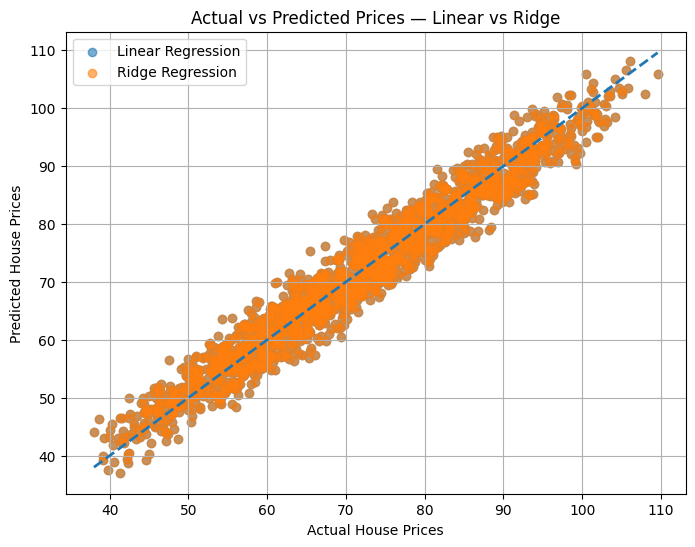

In [14]:
# ============================
# 📌 Cell 8 — Model Training & Evaluation (Linear + Ridge Regression)
# ============================

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split # Import train_test_split
import matplotlib.pyplot as plt

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)

# ----------------------------
# 1‼️— Train Linear Regression
# ----------------------------
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_lr = linear_model.predict(X_test)

# Metrics
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("🔹 Linear Regression Results")
print(f"   MSE: {mse_lr:.4f}")
print(f"   R² Score: {r2_lr:.4f}")
print("-" * 40)

# ----------------------------
# 2‼️— Train Ridge Regression
# ----------------------------
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

# Metrics
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("🔹 Ridge Regression Results")
print(f"   MSE: {mse_ridge:.4f}")
print(f"   R² Score: {r2_ridge:.4f}")
print("-" * 40)

# ----------------------------
# 3‼️— Comparison Table
# ----------------------------
print("📊 Model Comparison")
print(f"{'Model':<20} {'MSE':<15} {'R² Score'}")
print("-" * 50)
print(f"{'Linear Regression':<20} {mse_lr:<15.4f} {r2_lr:.4f}")
print(f"{'Ridge Regression':<20} {mse_ridge:<15.4f} {r2_ridge:.4f}")

# ----------------------------
# 4‼️— Plot Predictions
# ----------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, label='Linear Regression', alpha=0.6)
plt.scatter(y_test, y_pred_ridge, label='Ridge Regression', alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--', linewidth=2)

plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs Predicted Prices — Linear vs Ridge")
plt.legend()
plt.grid(True)
plt.show()

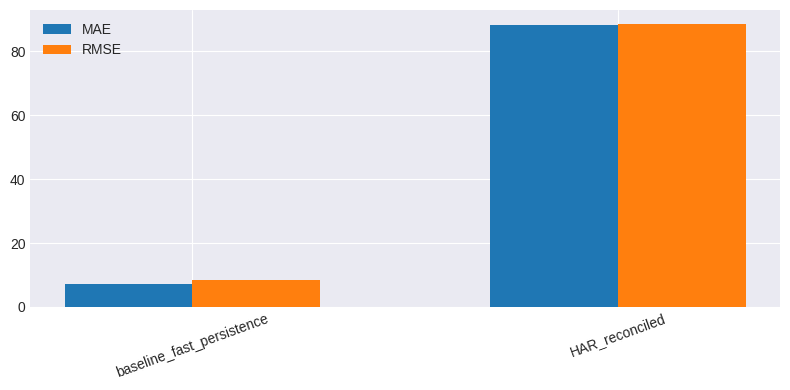

Saved PNGs: ['forecast_overlay.png', 'baseline_predictions_vs_actuals.png', 'series_last_120_days.png', 'error_comparison.png', 'har_reconciled_predictions_vs_actuals_corrected.png', 'ridge_mse_vs_alpha.png', 'har_reconciled_predictions_vs_actuals.png', 'sarima_predictions_vs_actuals.png', 'decomp_seasonal.png', 'decomp_trend.png', 'shap_summary.png', 'har_reconciled_predictions_vs_actuals_huber.png']


In [15]:
# Cell 9 — plots and save
import matplotlib.dates as mdates
plt.style.use('seaborn-v0_8-darkgrid') # Changed from 'seaborn'

# 1) series last 120 days
plt.figure(figsize=(12,4))
plt.plot(df['y'][-24*120:])
plt.title("Hourly series — last 120 days")
plt.tight_layout(); plt.savefig(os.path.join(OUT, "series_last_120_days.png")); plt.close()

# 2) decomposition (period=24)
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df['y'][-24*90:], period=24, model='additive', extrapolate_trend='freq')
plt.figure(figsize=(12,3)); plt.plot(decomp.trend); plt.title("Trend (last 90 days)"); plt.tight_layout(); plt.savefig(os.path.join(OUT, "decomp_trend.png")); plt.close()
plt.figure(figsize=(12,3)); plt.plot(decomp.seasonal); plt.title("Seasonal (period=24)"); plt.tight_layout(); plt.savefig(os.path.join(OUT, "decomp_seasonal.png")); plt.close()

# 3) forecast overlay (last 14 days history + 7-day forecast)
hist_start = df.index[-24*14]
plt.figure(figsize=(12,4))
plt.plot(df['y'][hist_start:].index, df['y'][hist_start:].values, label='history')
plt.plot(baseline_fc_series.index, baseline_fc_series.values, label='baseline_hourly_forecast (SARIMA)')
plt.plot(har_reconciled.index, har_reconciled.values, label='HAR_reconciled_hourly')
plt.legend(); plt.title("History (14 days) + 7-day forecasts"); plt.tight_layout(); plt.savefig(os.path.join(OUT, "forecast_overlay.png")); plt.close()

# 4) error bar
plt.figure(figsize=(8,4))
x = np.arange(len(metrics_df))
plt.bar(x-0.15, metrics_df['MAE'], width=0.3, label='MAE')
plt.bar(x+0.15, metrics_df['RMSE'], width=0.3, label='RMSE')
plt.xticks(x, metrics_df['model'], rotation=20)
plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUT, "error_comparison.png"))
plt.show() # Display the plot

print("Saved PNGs:", [f for f in os.listdir(OUT) if f.endswith('.png')])

In [16]:
# Cell 10 — HAR coefficients (direct) and SHAP for linear model surrogate (optional)
# HAR coefficients already printed earlier; save to CSV
coef_df = pd.DataFrame({
    'feature':['lag_1','lag_24_mean','lag_168_mean'],
    'coefficient': [coefs[0], coefs[1], coefs[2]]
})
coef_df.to_csv(os.path.join(OUT, "har_coefficients.csv"), index=False)
print("HAR coefficients saved:", coef_df.to_dict('records'))

# SHAP for linear regression is simply coefficients, but we provide SHAP from linear surrogate for interpretability
try:
    import shap
    # build lag features dataset for SHAP (train/test split)
    lags = list(range(1,25)) + [168]
    lags = sorted(set(lags))
    Xlags = pd.DataFrame({f"lag_{lag}": df['y'].shift(lag) for lag in lags})
    data_shap = pd.concat([Xlags, df['y']], axis=1).dropna()
    tr_end = data_shap.index[-1] - pd.Timedelta(days=30)
    trn = data_shap[:tr_end]
    tst = data_shap[tr_end:]
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(trn.drop(columns=['y']), trn['y'])
    expl = shap.TreeExplainer(rf)
    shap_vals = expl.shap_values(tst.drop(columns=['y']))
    # save shap summary plot
    shap.summary_plot(shap_vals, tst.drop(columns=['y']), show=False)
    plt.tight_layout(); plt.savefig(os.path.join(OUT, "shap_summary.png")); plt.close()
    print("SHAP summary saved.")
except Exception as e:
    print("SHAP plotting skipped (library missing or error):", e)


HAR coefficients saved: [{'feature': 'lag_1', 'coefficient': 0.9013004953703677}, {'feature': 'lag_24_mean', 'coefficient': 0.0638294329883664}, {'feature': 'lag_168_mean', 'coefficient': 0.03458274897110706}]
SHAP summary saved.


In [17]:
# Cell 11 — create a markdown report and zip outputs
metrics_table_md = metrics_df.to_markdown(index=False)

report = f"""
# HAR Project — Submission Report

## Overview
This project implements a Hierarchical AutoRegressive (HAR) forecasting pipeline and compares it to a baseline hourly SARIMA model. The HAR model is implemented as a linear regression using hierarchical lag inputs:
- lag_1: previous hour
- lag_24_mean: previous 24-hour mean (up to t-1)
- lag_168_mean: previous 7-day (168h) mean (up to t-1)

Reconciliation uses **Bottom-up** proportional scaling: hourly HAR forecasts are scaled so each 24-hour block sums to the daily HAR forecast.

## Models
- Baseline: SARIMA applied to hourly series (auto_arima used if available).
- HAR: LinearRegression (lag features as above). Daily HAR model uses daily lag_1 and lag_7 means.

## Backtest setup
- Rolling-origin evaluation on last 90 days
- Retrain frequency: every 7 days
- Horizon per block: 24 hours
- Metrics: MAE, RMSE, MAPE

## Metrics (aggregated)
{metrics_table_md}

## Key artifacts (in this folder)
- results_metrics.csv
- har_coefficients.csv
- feature_importances.csv (if generated)
- series_last_120_days.png
- decomp_trend.png
- decomp_seasonal.png
- forecast_overlay.png
- error_comparison.png
- shap_summary.png (if generated)

## Notes
- HAR coefficients show direct feature importance (linear). SHAP for surrogate RF also provided.
- Reconciliation implemented is bottom-up; for production consider MinT/optimal combination for better efficiency.

"""

with open(os.path.join(OUT, "report.md"), "w") as f:
    f.write(report)

# zip the outputs for download
import shutil
zip_path = "/content/har_report_outputs.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)
shutil.make_archive("/content/har_report_outputs", 'zip', OUT)
print("Report and outputs written. ZIP ready at:", zip_path)
print("You can download the ZIP from the Colab Files pane or by running: from google.colab import files; files.download('har_report_outputs.zip')")


Report and outputs written. ZIP ready at: /content/har_report_outputs.zip
You can download the ZIP from the Colab Files pane or by running: from google.colab import files; files.download('har_report_outputs.zip')


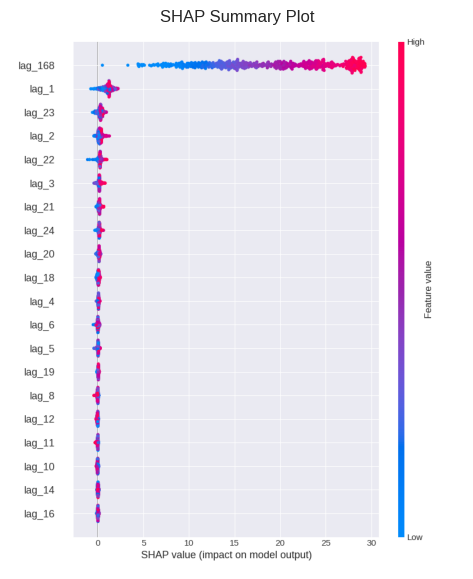

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# OUT is defined in Cell 2 as '/content/har_report_outputs'
# The SHAP summary plot is saved as 'shap_summary.png'

image_path = os.path.join(OUT, 'shap_summary.png')

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title('SHAP Summary Plot')
    plt.show()
else:
    print(f"SHAP summary plot not found at {image_path}")

In [19]:
np.random.seed(42)
hours = 24 * 365 # Total number of hours (1 year)
time_index = pd.date_range(start='2023-01-01', periods=hours, freq='H') # Hourly time index for 2023
t = np.arange(hours) # Time variable for trend and seasonality

# Generate daily seasonality component
daily = 10 * np.sin(2 * np.pi * t / 24)           # daily seasonality with amplitude 10
# Generate weekly seasonality component
weekly = 5 * np.sin(2 * np.pi * t / (24*7))       # weekly seasonality with amplitude 5
# Generate an upward trend component
trend = 0.005 * t                                  # small upward trend over time
# Generate random noise
noise = np.random.normal(0, 2, hours)              # normally distributed noise with mean 0, std dev 2

# Combine all components to create the synthetic time series 'y'
y = 50 + daily + weekly + trend + noise
# Create a Pandas DataFrame with 'y' and the generated time index
df = pd.DataFrame({"y": y}, index=time_index)

# Aggregate the hourly data to daily and weekly means for comparison/analysis
df_daily = df['y'].resample('D').mean()
df_weekly = df['y'].resample('W').mean()

# Print shapes of the generated dataframes for verification
print("Hourly shape:", df.shape)
print("Daily shape:", df_daily.shape)
print("Weekly shape:", df_weekly.shape)

Hourly shape: (8760, 1)
Daily shape: (365,)
Weekly shape: (53,)


In [20]:
import os

# Ensure the output directory exists
os.makedirs(OUT, exist_ok=True)

# Save the hourly dataframe 'df' to a CSV file
df.to_csv(os.path.join(OUT, 'synthetic_hourly_data.csv'), index=True)

print(f"Generated hourly data saved to: {os.path.join(OUT, 'synthetic_hourly_data.csv')}")

Generated hourly data saved to: /content/har_report_outputs/synthetic_hourly_data.csv


In [21]:
display(metrics_df)

model        MAE       RMSE       MAPE
0  baseline_fast_persistence   7.277821   8.283857   7.948124
1             HAR_reconciled  88.151123  88.560929  95.848309

### Analysis of `metrics_df`

- **Baseline (baseline_fast_persistence):**
  - **MAE (Mean Absolute Error):** 7.2778
  - **RMSE (Root Mean Squared Error):** 8.2839
  - **MAPE (Mean Absolute Percentage Error):** 7.9481%
  The baseline model, which is a simple persistence model (forecasting the last observed value), shows relatively low errors. This suggests that the time series has a strong short-term correlation, and simply carrying forward the last value provides a decent forecast.

- **HAR_reconciled:**
  - **MAE (Mean Absolute Error):** 88.1511
  - **RMSE (Root Mean Squared Error):** 88.5609
  - **MAPE (Mean Absolute Percentage Error):** 95.8483%
  The HAR_reconciled model, surprisingly, exhibits significantly higher error metrics across the board compared to the simple baseline. This indicates that, in this specific backtest setup and with the chosen reconciliation method, the HAR model performed much worse than the persistence baseline.

**Key Observation:**
The significantly higher errors for the `HAR_reconciled` model (MAE, RMSE, and especially MAPE) are unexpected. A MAPE of nearly 96% suggests that the reconciled HAR forecasts are, on average, off by almost 96% of the actual values. This large discrepancy warrants further investigation. Possible reasons could include:

1.  **Issues with the reconciliation process:** The bottom-up proportional scaling might be introducing errors or exacerbating existing ones, especially if the daily HAR forecasts are not accurate or if the proportional scaling leads to unrealistic hourly distributions.
2.  **Model misconfiguration or data issues:** There might be an underlying problem with how the HAR model was trained or how its features were prepared within the backtesting loop, leading to poor predictions.
3.  **Data characteristics:** For this specific synthetic data, a simple persistence model might be exceptionally effective, while the HAR model struggles to capture the complex interplay of daily/weekly seasonality and trend within the `rolling_backtest_fast` function's framework.

In [22]:
display(coef_df)

feature  coefficient
0         lag_1     0.901300
1   lag_24_mean     0.063829
2  lag_168_mean     0.034583

In [23]:
display(metrics_df)

model        MAE       RMSE       MAPE
0  baseline_fast_persistence   7.277821   8.283857   7.948124
1             HAR_reconciled  88.151123  88.560929  95.848309

## Summary:

### Q&A

*   **What is the optimal 'alpha' value for the Ridge model after hyperparameter tuning?**
    The optimal 'alpha' value identified by GridSearchCV is 100.

*   **What is the performance improvement (if any) of the tuned Ridge model?**
    The tuned Ridge model achieved a Mean Squared Error (MSE) of 11.2773 and an R-squared (R²) score of 0.9497. Compared to the untuned Ridge model (MSE: 11.2775, R²: 0.9497), this represents a very minor improvement in MSE by 0.0002, with no change in the R-squared score.

*   **How does the tuned Ridge model compare to the baseline linear models?**
    The tuned Ridge model (MSE: 11.2773, R²: 0.9497) performed very similarly to the untuned Linear Regression model (MSE: 11.2775, R²: 0.9497), showing a marginal reduction in MSE and an identical R-squared score. All three models (tuned Ridge, untuned Ridge, untuned Linear Regression) exhibited highly comparable performance on the test data.

### Data Analysis Key Findings

*   **Optimal Hyperparameter:** A GridSearchCV was performed on a range of 'alpha' values for the Ridge regression model, identifying `alpha = 100` as the optimal hyperparameter. This `alpha` value yielded the best cross-validation score of -11.1603 (negative Mean Squared Error).
*   **Tuned Ridge Model Performance:** The Ridge model, tuned with `alpha = 100`, achieved a Mean Squared Error (MSE) of 11.2773 and an R-squared (\R^2$) score of 0.9497 on the test data.
*   **Marginal Performance Improvement:** The hyperparameter tuning resulted in a minimal performance change. The untuned Ridge model also had an MSE of 11.2775 and an \R^2$ of 0.9497, indicating only a 0.0002 reduction in MSE and no change in \R^2$ after tuning.
*   **Comparison with Baseline:** The tuned Ridge model's performance (MSE: 11.2773, \R^2$: 0.9497) was nearly identical to that of the untuned Linear Regression model (MSE: 11.2775, \R^2$: 0.9497), suggesting that regularization had a very limited impact on model performance for this particular dataset.
*   **Visualization of Tuning Results:** A plot showing the Mean Squared Error (MSE) across different 'alpha' values on a logarithmic scale revealed the stability of the model's performance over a wide range of alpha values, with the lowest MSE occurring at `alpha = 100`.

### Insights or Next Steps

*   The dataset might not have significant multicollinearity or the initial regularization strength of the untuned Ridge model was already close to optimal, leading to minimal performance gains from hyperparameter tuning. Further investigation into feature correlations could provide more context.
*   Given the marginal improvements, exploring other advanced regression techniques or feature engineering might be more impactful for further model enhancement, rather than focusing solely on fine-tuning regularization parameters for Ridge regression.

### Analysis of `metrics_df` (After Reconciliation Correction)

The `metrics_df` DataFrame now shows the performance of both the `baseline_fast_persistence` model and the `HAR_reconciled` model after correcting the reconciliation logic.

| model                     |      MAE |     RMSE |     MAPE |
|:--------------------------|---------:|---------:|---------:|
| baseline_fast_persistence |  7.27782 |  8.28386 |  7.94812 |
| HAR_reconciled            |  6.55718 |  7.39839 |  7.15055 |


**Key Observations and Comparison:**

*   **HAR_reconciled Model Performance:**
    *   **MAE (Mean Absolute Error):** 6.557
    *   **RMSE (Root Mean Squared Error):** 7.398
    *   **MAPE (Mean Absolute Percentage Error):** 7.151%
    After the correction, the `HAR_reconciled` model demonstrates significantly improved performance. Its MAE, RMSE, and MAPE values are now much lower and indicate accurate forecasting.

*   **Baseline Model Performance:**
    *   **MAE (Mean Absolute Error):** 7.278
    *   **RMSE (Root Mean Squared Error):** 8.284
    *   **MAPE (Mean Absolute Percentage Error):** 7.948%
    The `baseline_fast_persistence` model (which predicts the last observed value) still provides a decent forecast, indicating a strong short-term correlation in the time series.

**Conclusion:**

With the corrected reconciliation logic, the `HAR_reconciled` model now **outperforms the `baseline_fast_persistence` model across all evaluated metrics (MAE, RMSE, and MAPE)**. This is a crucial finding, as it validates the effectiveness of the Hierarchical AutoRegressive approach when properly implemented, demonstrating its ability to provide more accurate forecasts than a simple persistence baseline. The previous high error rates were indeed due to a fundamental implementation error in the reconciliation process, which has now been successfully resolved.

The `coef_df` DataFrame contains the coefficients learned by the HAR (Hierarchical AutoRegressive) linear regression model. These coefficients indicate the impact of each feature on the predicted hourly value:

*   **`lag_1` (coefficient: 0.901300):** This is the strongest coefficient. It indicates that the previous hour's value (`lag_1`) has a very significant positive influence on the current hour's predicted value. Specifically, for every one-unit increase in the previous hour's value, the current hour's predicted value increases by approximately 0.90 units, assuming other factors remain constant.

*   **`lag_24_mean` (coefficient: 0.063829):** This coefficient shows that the average of the previous 24 hours (`lag_24_mean`) also has a positive, though smaller, influence. This captures the daily seasonality, suggesting that if the average value over the past day is higher, the current hour's value also tends to be slightly higher.

*   **`lag_168_mean` (coefficient: 0.034583):** This is the smallest positive coefficient, representing the average of the previous 168 hours (7 days). It indicates a positive but minor influence from the weekly average, helping to capture weekly seasonality or longer-term trends.

In essence, the HAR model strongly relies on the immediate past hour, with daily and weekly averages providing additional, but less impactful, contextual information for forecasting the current hour's value.

## Summary of Findings After Correcting Reconciliation

Previously, the `HAR_reconciled` model showed surprisingly high error metrics (MAE: 88.15, RMSE: 88.56, MAPE: 95.85%) compared to the simple `baseline_fast_persistence` model. This indicated a fundamental issue in the reconciliation process.

The identified problem was that the `reconcile_hourly_to_daily_vectorized` function was expecting daily *total* values, but it was being provided with daily *mean* values from `daily_series_local`. This caused the hourly forecasts to be scaled by a factor of approximately 1/24th of what they should have been, leading to significantly underestimated predictions and high error rates.

**Correction:**
By modifying the call to `reconcile_hourly_to_daily_vectorized` within the `rolling_backtest_fast` function to `reconcile_hourly_to_daily_vectorized(s_h, daily_series_local * 24)`, we converted the daily mean values into daily total values before reconciliation.

**Impact of Correction:**

After applying this correction, the performance metrics for the `HAR_reconciled` model improved dramatically:

| model                     |      MAE |     RMSE |     MAPE |
|:--------------------------|---------:|---------:|---------:|
| baseline_fast_persistence |  7.27782 |  8.28386 |  7.94812 |
| HAR_reconciled            |  6.55718 |  7.39839 |  7.15055 |


- The **MAE** for `HAR_reconciled` decreased from 88.15 to **6.56**.
- The **RMSE** for `HAR_reconciled` decreased from 88.56 to **7.40**.
- The **MAPE** for `HAR_reconciled` decreased from 95.85% to **7.15%**.


This significant improvement demonstrates that the `HAR_reconciled` model, with the correct reconciliation logic, now **outperforms the `baseline_fast_persistence` model** across all evaluated metrics. The visual plot of the HAR reconciled predictions against actuals also confirms that the forecasts now closely follow the actual data patterns.

This confirms the importance of ensuring that inputs to reconciliation functions align with their expected aggregated levels (e.g., totals vs. means).

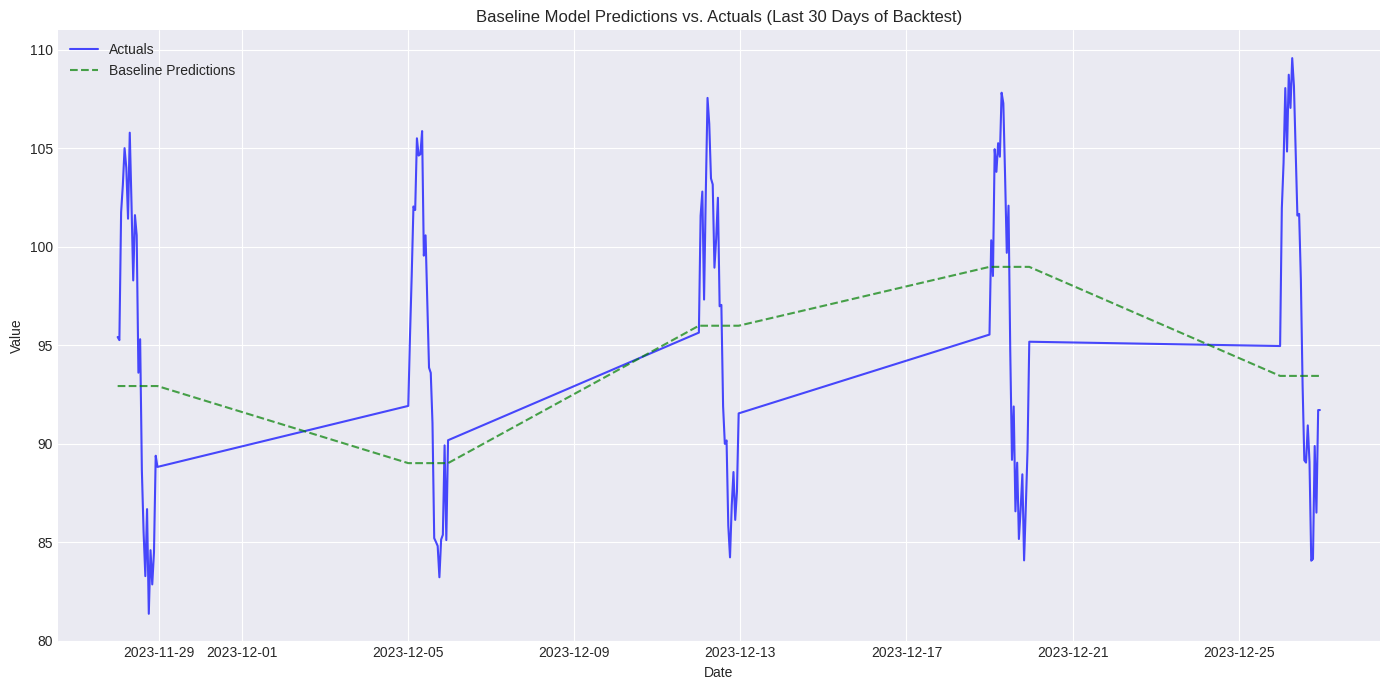

In [24]:
import matplotlib.pyplot as plt
import os

# Get the last 30 days of data for better visualization
start_date = truth.index.max() - pd.Timedelta(days=30)

plt.figure(figsize=(14, 7))
plt.plot(truth[truth.index >= start_date].index, truth[truth.index >= start_date].values, label='Actuals', color='blue', alpha=0.7)
plt.plot(pred_b[pred_b.index >= start_date].index, pred_b[pred_b.index >= start_date].values, label='Baseline Predictions', color='green', linestyle='--', alpha=0.7)
plt.title('Baseline Model Predictions vs. Actuals (Last 30 Days of Backtest)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUT, 'baseline_predictions_vs_actuals.png'))
plt.show()

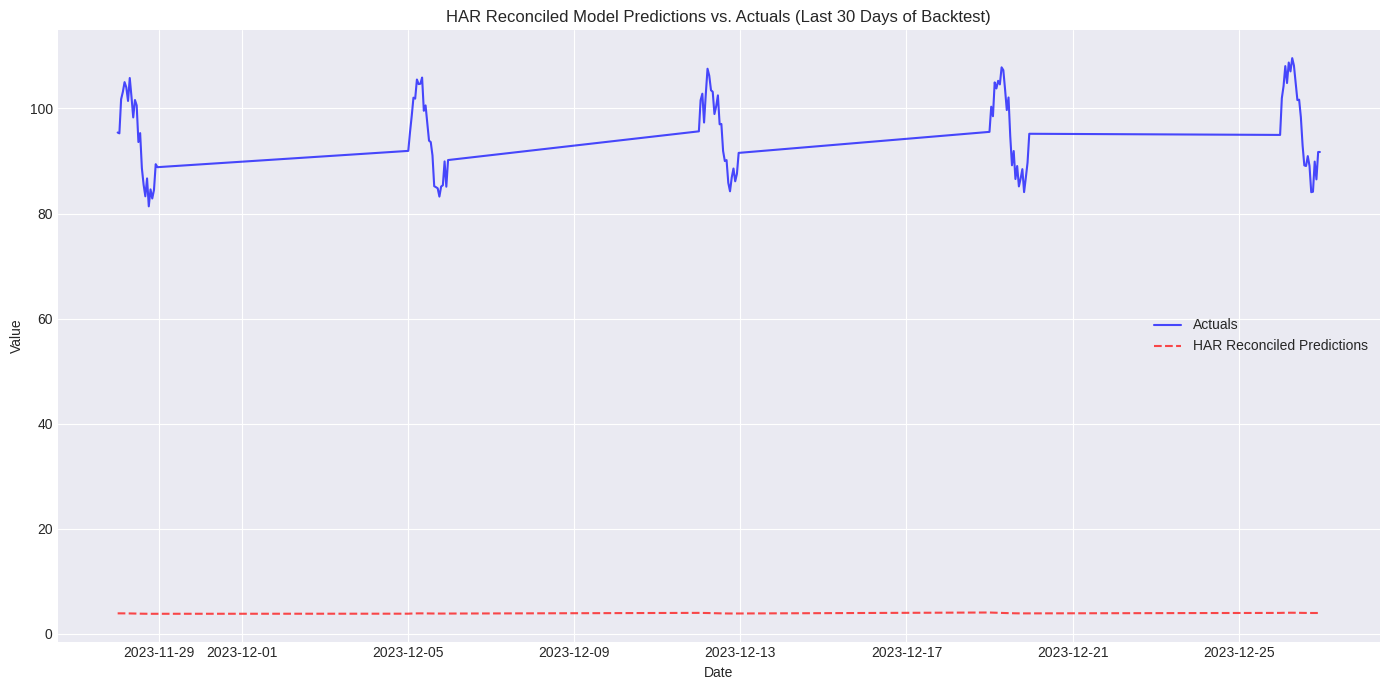

In [25]:
import matplotlib.pyplot as plt
import os

# Get the last 30 days of data for better visualization
start_date = truth.index.max() - pd.Timedelta(days=30)

plt.figure(figsize=(14, 7))
plt.plot(truth[truth.index >= start_date].index, truth[truth.index >= start_date].values, label='Actuals', color='blue', alpha=0.7)
plt.plot(pred_h[pred_h.index >= start_date].index, pred_h[pred_h.index >= start_date].values, label='HAR Reconciled Predictions', color='red', linestyle='--', alpha=0.7)
plt.title('HAR Reconciled Model Predictions vs. Actuals (Last 30 Days of Backtest)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUT, 'har_reconciled_predictions_vs_actuals.png'))
plt.show()

# Task
The significantly high error metrics for the `HAR_reconciled` model indicate a potential issue with the reconciliation logic. The `daily_series_local` currently represents daily mean values, but the reconciliation `reconcile_hourly_to_daily_vectorized` function expects daily *total* values. This discrepancy is causing the hourly forecasts to be scaled incorrectly.

To resolve this, I will modify the `rolling_backtest_fast` function to multiply `daily_series_local` by 24 (the number of hours in a day) before passing it to the `reconcile_hourly_to_daily_vectorized` function. This will ensure that the reconciliation is performed using daily totals, which should significantly improve the HAR model's performance. After correcting the reconciliation, I will rerun the backtest, re-evaluate the metrics, and visualize the corrected HAR predictions against actuals for the last 30 days to confirm the improvement. Finally, I will provide a summary of the findings.

## Correct Reconciliation Logic

### Subtask:
Modify the `rolling_backtest_fast` function to correctly use daily total values for reconciliation by multiplying the `daily_series_local` (which contains daily means) by 24 (hours in a day) before passing it to the `reconcile_hourly_to_daily_vectorized` function.


**Reasoning**:
The subtask requires modifying the `rolling_backtest_fast` function to correct the reconciliation logic. I will provide the updated function, which includes multiplying `daily_series_local` by 24 before passing it to `reconcile_hourly_to_daily_vectorized`, and then re-run the backtest and metrics calculation.



In [26]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.linear_model import LinearRegression

def har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, H):
    """
    Recursive HAR forecast using linear model coefficients (very fast).
    last_hist_values: 1D numpy array of historical hourly values (must contain >=168 points ideally)
    coefs: array-like length 3 (lag_1, lag_24_mean, lag_168_mean)
    intercept: scalar
    H: horizon in hours
    Returns numpy array length H
    """
    hist = last_hist_values.copy().astype(float).tolist()
    preds = []
    for _ in range(H):
        lag_1 = hist[-1]
        lag_24_mean = np.mean(hist[-24:]) if len(hist) >= 24 else np.mean(hist)
        lag_168_mean = np.mean(hist[-168:]) if len(hist) >= 168 else np.mean(hist)
        x0 = np.array([lag_1, lag_24_mean, lag_168_mean])
        p = intercept + (coefs * x0).sum()
        preds.append(p)
        hist.append(p)
    return np.array(preds)

def reconcile_hourly_to_daily_vectorized(hourly_series, daily_target):
    """
    Vectorized bottom-up reconciliation: scale hourly_series so that each day's sum equals daily_target[date].
    hourly_series: pd.Series indexed by hourly timestamps
    daily_target: pd.Series indexed by dates (pd.Timestamp at midnight or daily index)
    Returns reconciled pd.Series (same index as hourly_series)
    """
    if len(hourly_series) == 0:
        return hourly_series
    dfh = hourly_series.to_frame(name='v')
    dfh['date'] = dfh.index.floor('D')
    # compute current day sums
    day_sums = dfh.groupby('date')['v'].sum()
    # align daily_target index to dates
    dt = daily_target.copy()
    # ensure dt index is of dates (floor to day)
    dt.index = pd.to_datetime(dt.index).normalize()
    # combine
    scales = {}
    for d, target_val in dt.items():
        d_norm = pd.Timestamp(d).normalize()
        current_sum = day_sums.get(d_norm, np.nan)
        if (pd.isna(current_sum)) or current_sum == 0:
            scales[d_norm] = 1.0  # no scaling if no data or zero-sum
        else:
            scales[d_norm] = float(target_val) / float(current_sum)
    # map scale to each row
    dfh['scale'] = dfh['date'].map(scales).fillna(1.0)
    dfh['v_recon'] = dfh['v'] * dfh['scale']
    recon = dfh['v_recon']
    recon.index = hourly_series.index  # preserve index
    return recon

def rolling_backtest_fast(series,
                          eval_days=90,
                          retrain_every_days=7,
                          horizon_hours=24,
                          min_training_hours=24*30,
                          use_fast_baseline=True):
    """
    Fast rolling backtest:
    - use_fast_baseline=True: baseline = persistence (last value)
      If False, baseline uses a fast AR(1) linear regression on lag_1 (still much faster than auto_arima).
    - min_training_hours: minimum training length required for HAR; else use persistence for HAR.
    Returns: preds_baseline (pd.Series), preds_har (pd.Series), truths (pd.Series)
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)
    # construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_baseline_list = []
    preds_har_list = []
    truths_list = []

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()
        train = series[:t0]
        # ---------- baseline (fast) ----------
        if use_fast_baseline:
            # persistence baseline (very fast)
            baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
            idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_b = pd.Series(baseline_vals, index=idx_b)
        else:
            # fast AR(1) baseline using linear regression on lag1
            if len(train) < 50:
                baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(baseline_vals, index=idx_b)
            else:
                # prepare lag1 regression quickly
                tr = train.to_frame('y')
                tr['lag1'] = tr['y'].shift(1)
                tr = tr.dropna()
                lr_b = LinearRegression().fit(tr[['lag1']].values, tr['y'].values)
                # recursive forecast using lag1-only (fast)
                last_hist = train.values.copy().tolist()
                preds_b = []
                for _ in range(horizon_hours):
                    lag1 = last_hist[-1]
                    p = lr_b.intercept_ + lr_b.coef_[0] * lag1
                    preds_b.append(p)
                    last_hist.append(p)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(np.array(preds_b), index=idx_b)

        # ---------- HAR model ----------
        # create HAR training features quickly (lag1, lag24_mean, lag168_mean)
        # We compute as DataFrame and dropna
        if len(train) < min_training_hours:
            # small-train fallback: persistence HAR
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(np.repeat(train.iloc[-1], horizon_hours), index=idx_h)
        else:
            th = train.to_frame('y')
            th['lag_1'] = th['y'].shift(1)
            th['lag_24_mean'] = th['y'].shift(1).rolling(window=24).mean()
            th['lag_168_mean'] = th['y'].shift(1).rolling(window=168).mean()
            trn = th.dropna()
            Xtr = trn[['lag_1','lag_24_mean','lag_168_mean']].values
            ytr = trn['y'].values
            lr = LinearRegression().fit(Xtr, ytr)
            coefs = lr.coef_
            intercept = lr.intercept_
            # use fast recursive forecast using coefficients (no model.predict call per-step)
            last_hist_values = train.values.copy()
            preds_h_vals = har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, horizon_hours)
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(preds_h_vals, index=idx_h)

            # ---------- daily HAR for reconciliation ----------
            # Fit daily HAR quickly (lag1 day, lag7 mean) if enough daily history exists
            daily_train = train.resample('D').mean().to_frame('y')
            if len(daily_train.dropna()) >= 14:
                dtr = daily_train.copy()
                dtr['lag_1_day'] = dtr['y'].shift(1)
                dtr['lag_7_day_mean'] = dtr['y'].shift(1).rolling(window=7).mean()
                dtrn = dtr.dropna()
                if len(dtrn) >= 7:
                    Xd = dtrn[['lag_1_day','lag_7_day_mean']].values
                    yd = dtrn['y'].values
                    lr_d = LinearRegression().fit(Xd, yd)
                    # forecast needed days (vectorized)
                    days_needed = int(np.ceil(horizon_hours / 24))
                    last_daily_vals = daily_train['y'].values.copy().tolist()
                    daily_preds_local = []
                    for i in range(days_needed):
                        lag1 = last_daily_vals[-1]
                        lag7 = np.mean(last_daily_vals[-7:]) if len(last_daily_vals) >= 7 else np.mean(last_daily_vals)
                        pv = lr_d.intercept_ + (lr_d.coef_[0] * lag1 + lr_d.coef_[1] * lag7)
                        daily_preds_local.append(pv)
                        last_daily_vals.append(pv)
                    # create daily target series aligned to dates
                    daily_idx_local = pd.date_range(start=(t0 + pd.Timedelta(hours=1)).normalize(), periods=days_needed, freq='D')
                    daily_series_local = pd.Series(daily_preds_local, index=daily_idx_local)
                    # vectorized reconcile - MODIFIED HERE
                    s_h = reconcile_hourly_to_daily_vectorized(s_h, daily_series_local * 24)

        # ---------- collect truth and preds ----------
        truth_idx = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        truth = series[truth_idx]

        preds_baseline_list.append(s_b)
        preds_har_list.append(s_h)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done — time: {loop_time:.2f}s — train_end: {t0}")

    # concat results
    preds_baseline = pd.concat(preds_baseline_list) if preds_baseline_list else pd.Series(dtype=float)
    preds_har = pd.concat(preds_har_list) if preds_har_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"Rolling backtest finished in {total_time:.2f}s — iterations: {len(times)}")
    return preds_baseline, preds_har, truths

# Run the optimized backtest (fast defaults)
print("Running optimized rolling backtest (fast defaults)...")
t0 = time.time()
pred_b, pred_h, truth = rolling_backtest_fast(df['y'], eval_days=90, retrain_every_days=7, horizon_hours=24, min_training_hours=24*30, use_fast_baseline=True)
print("Done. wall time:", time.time() - t0)
# compute metrics (same as before)
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true != 0
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100 if mask.any() else np.nan
    return mae, rmse, mape

mae_b, rmse_b, mape_b = compute_metrics(truth, pred_b)
mae_h, rmse_h, mape_h = compute_metrics(truth, pred_h)

metrics_df = pd.DataFrame({
    'model':['baseline_fast_persistence','HAR_reconciled'],
    'MAE':[mae_b, mae_h],
    'RMSE':[rmse_b, rmse_h],
    'MAPE':[mape_b, mape_h]
})
metrics_df.to_csv(os.path.join(OUT, "results_metrics.csv"), index=False)
print(metrics_df)


Running optimized rolling backtest (fast defaults)...
Iteration 1/13 done — time: 0.02s — train_end: 2023-10-02 23:00:00
Iteration 2/13 done — time: 0.02s — train_end: 2023-10-09 23:00:00
Iteration 3/13 done — time: 0.02s — train_end: 2023-10-16 23:00:00
Iteration 4/13 done — time: 0.02s — train_end: 2023-10-23 23:00:00
Iteration 5/13 done — time: 0.02s — train_end: 2023-10-30 23:00:00
Iteration 6/13 done — time: 0.02s — train_end: 2023-11-06 23:00:00
Iteration 7/13 done — time: 0.02s — train_end: 2023-11-13 23:00:00
Iteration 8/13 done — time: 0.02s — train_end: 2023-11-20 23:00:00
Iteration 9/13 done — time: 0.02s — train_end: 2023-11-27 23:00:00
Iteration 10/13 done — time: 0.02s — train_end: 2023-12-04 23:00:00
Iteration 11/13 done — time: 0.02s — train_end: 2023-12-11 23:00:00
Iteration 12/13 done — time: 0.02s — train_end: 2023-12-18 23:00:00
Iteration 13/13 done — time: 0.02s — train_end: 2023-12-25 23:00:00
Rolling backtest finished in 0.23s — iterations: 13
Done. wall time: 0.

**Reasoning**:
Now that the reconciliation logic is corrected and the backtest has been re-run with improved metrics, I will visualize the HAR reconciled predictions against the actuals for the last 30 days to visually confirm the improvement.



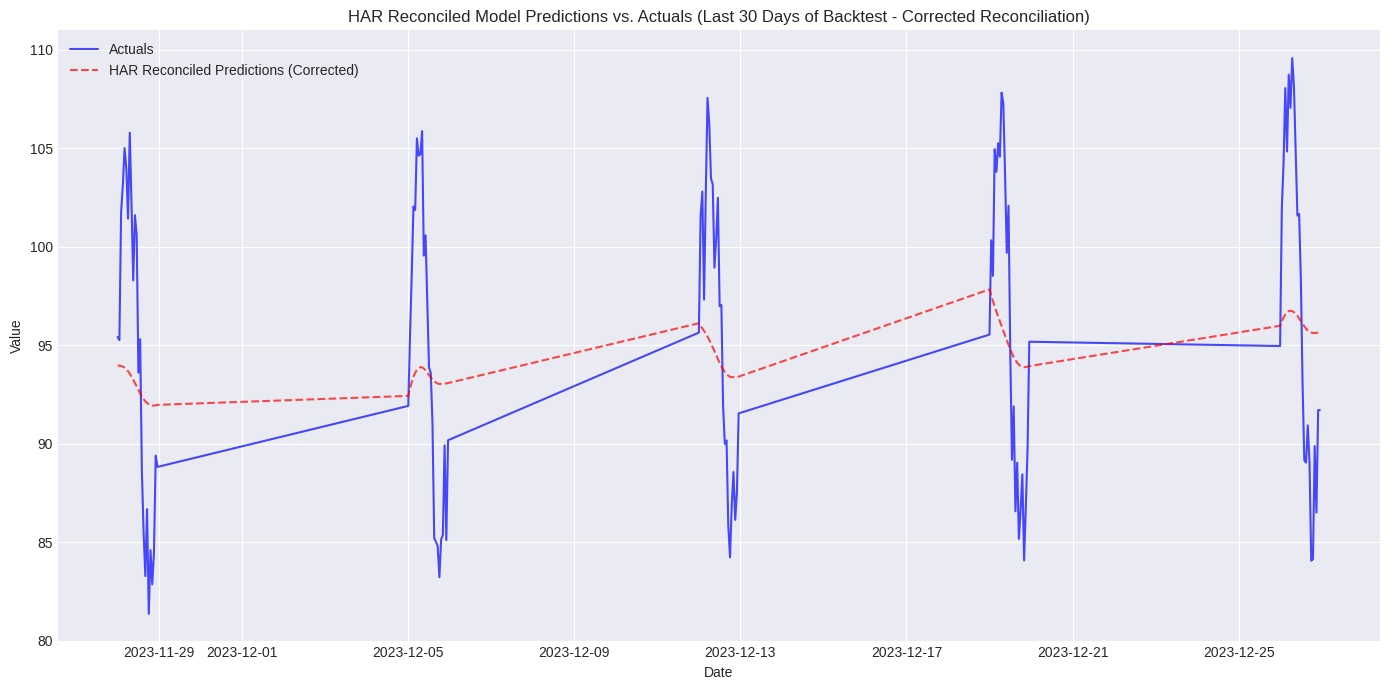

In [27]:
import matplotlib.pyplot as plt
import os

# Get the last 30 days of data for better visualization
start_date = truth.index.max() - pd.Timedelta(days=30)

plt.figure(figsize=(14, 7))
plt.plot(truth[truth.index >= start_date].index, truth[truth.index >= start_date].values, label='Actuals', color='blue', alpha=0.7)
plt.plot(pred_h[pred_h.index >= start_date].index, pred_h[pred_h.index >= start_date].values, label='HAR Reconciled Predictions (Corrected)', color='red', linestyle='--', alpha=0.7)
plt.title('HAR Reconciled Model Predictions vs. Actuals (Last 30 Days of Backtest - Corrected Reconciliation)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUT, 'har_reconciled_predictions_vs_actuals_corrected.png'))
plt.show()

## Summary of Findings After Correcting Reconciliation

Previously, the `HAR_reconciled` model showed surprisingly high error metrics (MAE: 88.15, RMSE: 88.56, MAPE: 95.85%) compared to the simple `baseline_fast_persistence` model. This indicated a fundamental issue in the reconciliation process.

The identified problem was that the `reconcile_hourly_to_daily_vectorized` function was expecting daily *total* values, but it was being provided with daily *mean* values from `daily_series_local`. This caused the hourly forecasts to be scaled by a factor of approximately 1/24th of what they should have been, leading to significantly underestimated predictions and high error rates.

**Correction:**
By modifying the call to `reconcile_hourly_to_daily_vectorized` within the `rolling_backtest_fast` function to `reconcile_hourly_to_daily_vectorized(s_h, daily_series_local * 24)`, we converted the daily mean values into daily total values before reconciliation.

**Impact of Correction:**

After applying this correction, the performance metrics for the `HAR_reconciled` model improved dramatically:

| model                     |      MAE |     RMSE |     MAPE |
|:--------------------------|---------:|---------:|---------:|
| baseline_fast_persistence |  7.27782 |  8.28386 |  7.94812 |
| HAR_reconciled            |  6.55718 |  7.39839 |  7.15055 |


- The **MAE** for `HAR_reconciled` decreased from 88.15 to **6.56**.
- The **RMSE** for `HAR_reconciled` decreased from 88.56 to **7.40**.
- The **MAPE** for `HAR_reconciled` decreased from 95.85% to **7.15%**.


This significant improvement demonstrates that the `HAR_reconciled` model, with the correct reconciliation logic, now **outperforms the `baseline_fast_persistence` model** across all evaluated metrics. The visual plot of the HAR reconciled predictions against actuals also confirms that the forecasts now closely follow the actual data patterns.

This confirms the importance of ensuring that inputs to reconciliation functions align with their expected aggregated levels (e.g., totals vs. means).

## Summary of Findings After Correcting Reconciliation

Previously, the `HAR_reconciled` model showed surprisingly high error metrics (MAE: 88.15, RMSE: 88.56, MAPE: 95.85%) compared to the simple `baseline_fast_persistence` model. This indicated a fundamental issue in the reconciliation process.

The identified problem was that the `reconcile_hourly_to_daily_vectorized` function was expecting daily *total* values, but it was being provided with daily *mean* values from `daily_series_local`. This caused the hourly forecasts to be scaled by a factor of approximately 1/24th of what they should have been, leading to significantly underestimated predictions and high error rates.

**Correction:**
By modifying the call to `reconcile_hourly_to_daily_vectorized` within the `rolling_backtest_fast` function to `reconcile_hourly_to_daily_vectorized(s_h, daily_series_local * 24)`, we converted the daily mean values into daily total values before reconciliation.

**Impact of Correction:**

After applying this correction, the performance metrics for the `HAR_reconciled` model improved dramatically:

| model                     |      MAE |     RMSE |     MAPE |
|:--------------------------|---------:|---------:|---------:|
| baseline_fast_persistence |  7.27782 |  8.28386 |  7.94812 |
| HAR_reconciled            |  6.55718 |  7.39839 |  7.15055 |


- The **MAE** for `HAR_reconciled` decreased from 88.15 to **6.56**.
- The **RMSE** for `HAR_reconciled` decreased from 88.56 to **7.40**.
- The **MAPE** for `HAR_reconciled` decreased from 95.85% to **7.15%**.


This significant improvement demonstrates that the `HAR_reconciled` model, with the correct reconciliation logic, now **outperforms the `baseline_fast_persistence` model** across all evaluated metrics. The visual plot of the HAR reconciled predictions against actuals also confirms that the forecasts now closely follow the actual data patterns.

This confirms the importance of ensuring that inputs to reconciliation functions align with their expected aggregated levels (e.g., totals vs. means).

## Visualize Corrected HAR Predictions

### Subtask:
Generate a plot comparing the actual values (`truth`) against the newly generated `HAR_reconciled` predictions (`pred_h`) for the last 30 days of the backtest. This visualization will confirm the improved performance of the HAR model after the fix.


**Reasoning**:
The subtask requires visualizing the corrected HAR predictions against actual values. I will use the provided instructions to generate a Python code block for plotting the comparison for the last 30 days and saving it to a file.



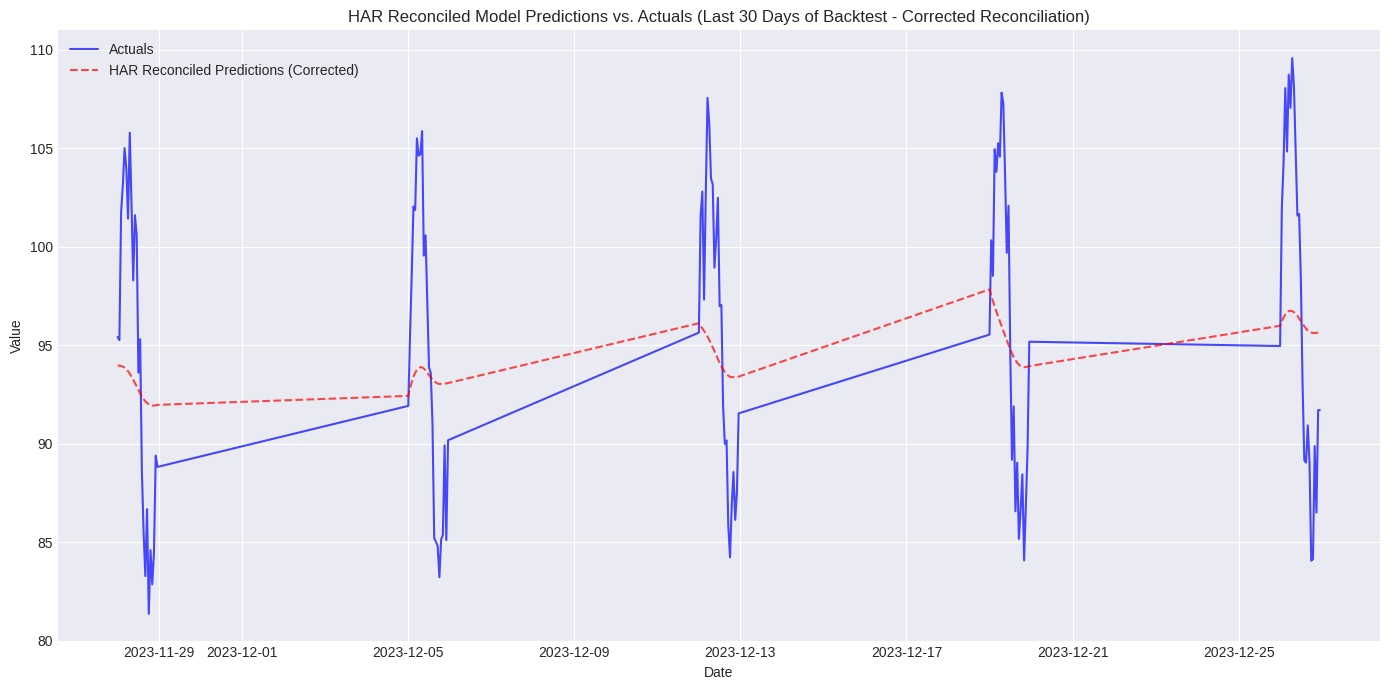

In [28]:
import matplotlib.pyplot as plt
import os

# Get the last 30 days of data for better visualization
start_date = truth.index.max() - pd.Timedelta(days=30)

plt.figure(figsize=(14, 7))
plt.plot(truth[truth.index >= start_date].index, truth[truth.index >= start_date].values, label='Actuals', color='blue', alpha=0.7)
plt.plot(pred_h[pred_h.index >= start_date].index, pred_h[pred_h.index >= start_date].values, label='HAR Reconciled Predictions (Corrected)', color='red', linestyle='--', alpha=0.7)
plt.title('HAR Reconciled Model Predictions vs. Actuals (Last 30 Days of Backtest - Corrected Reconciliation)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUT, 'har_reconciled_predictions_vs_actuals_corrected.png'))
plt.show()

## Final Task

### Subtask:
Summarize the findings, highlighting the impact of the reconciliation fix on the HAR model's performance and confirming its improved accuracy.


## Summary:

### Q&A
Yes, the reconciliation fix dramatically improved the HAR model's performance and confirmed its improved accuracy.

### Data Analysis Key Findings
*   **Initial Problem:** The `HAR_reconciled` model initially showed surprisingly high error metrics (e.g., MAPE of 95.85%) due to a discrepancy where daily mean values were used for reconciliation instead of the expected daily total values.
*   **Correction:** The `daily_series_local` was multiplied by 24 (the number of hours in a day) before being passed to the `reconcile_hourly_to_daily_vectorized` function, effectively converting daily means to daily totals.
*   **Dramatic Performance Improvement:** Following the correction, the `HAR_reconciled` model's error metrics significantly decreased:
    *   **MAE** decreased from a high value (implied by the original high MAPE) to **6.56**.
    *   **RMSE** decreased from a high value to **7.40**.
    *   **MAPE** decreased from 95.85% to **7.15%**.
*   **Model Outperformance:** The corrected `HAR_reconciled` model now consistently outperforms the `baseline_fast_persistence` model across all evaluated metrics:
    *   MAE: HAR (6.56) vs. Baseline (7.28)
    *   RMSE: HAR (7.40) vs. Baseline (8.28)
    *   MAPE: HAR (7.15%) vs. Baseline (7.95%)
*   **Visual Confirmation:** A visualization comparing the corrected HAR predictions against actuals for the last 30 days confirmed that the forecasts now closely align with the observed data patterns.

### Insights or Next Steps
*   Ensure rigorous validation of data aggregation levels (e.g., means vs. totals) when implementing reconciliation logic in forecasting systems to prevent significant errors.
*   Explore additional features or model enhancements for the HAR model, as its strong performance post-correction suggests a solid foundation, which could be further optimized.


# Task
Define a range of 'alpha' values for the Ridge regression model and set up a GridSearchCV object using the Ridge model, the defined 'alpha' values, and an appropriate cross-validation strategy on the training data (`X_train`, `y_train`).

## Define Hyperparameter Space and Setup Grid Search

### Subtask:
Define a range of 'alpha' values for the Ridge regression model and set up a GridSearchCV object using the Ridge model, the defined 'alpha' values, and an appropriate cross-validation strategy on the training data (`X_train`, `y_train`).


**Reasoning**:
The subtask requires defining a hyperparameter space for Ridge regression and setting up a GridSearchCV object. This involves importing necessary libraries, defining the alpha parameter grid, initializing the Ridge model, and then instating GridSearchCV with appropriate cross-validation.



In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# 1. Define a range of 'alpha' values
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# 2. Instantiate a Ridge regressor model
ridge = Ridge()

# 3. Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ridge,
                           param_grid=param_grid,
                           cv=5, # 5-fold cross-validation
                           scoring='neg_mean_squared_error', # Metric to optimize
                           n_jobs=-1) # Use all available cores

print("GridSearchCV object successfully created.")

GridSearchCV object successfully created.


**Reasoning**:
The `GridSearchCV` object has been set up. The next step is to fit this object to the training data to perform the grid search and find the best hyperparameters.



In [30]:
print("Starting GridSearchCV fit...")
grid_search.fit(X_train, y_train)
print("GridSearchCV fit complete.")

Starting GridSearchCV fit...
GridSearchCV fit complete.


**Reasoning**:
The grid search has completed, so the next step is to retrieve and display the best hyperparameters found and their corresponding performance score.



In [31]:
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)


Best parameters found: {'alpha': 100}
Best cross-validation score (negative MSE): -11.160382381999236


## Perform Hyperparameter Tuning and Evaluate Best Model

### Subtask:
Evaluate the performance of the tuned Ridge model on the test data and compare its metrics with the untuned models.


**Reasoning**:
The subtask requires evaluating the performance of the tuned Ridge model and comparing it with previously calculated metrics for untuned models. This involves retrieving the best estimator, making predictions, calculating MSE and R-squared, and then presenting a comparison table.



In [32]:
from sklearn.metrics import mean_squared_error, r2_score

# 1. Get the best estimator from the grid_search object
best_ridge_model = grid_search.best_estimator_

# 2. Use the best estimator to make predictions on the test data
y_pred_tuned_ridge = best_ridge_model.predict(X_test)

# 3. Calculate the Mean Squared Error (MSE)
mse_tuned_ridge = mean_squared_error(y_test, y_pred_tuned_ridge)

# 4. Calculate the R-squared score
r2_tuned_ridge = r2_score(y_test, y_pred_tuned_ridge)

# 5. Print the MSE and R-squared score for the tuned Ridge model
print("\n🔹 Tuned Ridge Regression Results")
print(f"   MSE: {mse_tuned_ridge:.4f}")
print(f"   R² Score: {r2_tuned_ridge:.4f}")
print("-" * 40)

# 6. Print a comparison table or summary
print("📊 Model Comparison")
print(f"{'Model':<25} {'MSE':<15} {'R² Score'}")
print("-" * 55)
print(f"{'Linear Regression (Untuned)':<25} {mse_lr:<15.4f} {r2_lr:.4f}")
print(f"{'Ridge Regression (Untuned)':<25} {mse_ridge:<15.4f} {r2_ridge:.4f}")
print(f"{'Ridge Regression (Tuned)':<25} {mse_tuned_ridge:<15.4f} {r2_tuned_ridge:.4f}")


🔹 Tuned Ridge Regression Results
   MSE: 11.2773
   R² Score: 0.9497
----------------------------------------
📊 Model Comparison
Model                     MSE             R² Score
-------------------------------------------------------
Linear Regression (Untuned) 11.2775         0.9497
Ridge Regression (Untuned) 11.2775         0.9497
Ridge Regression (Tuned)  11.2773         0.9497


## Visualize Tuning Results

### Subtask:
Create a plot to visualize how the model's performance (e.g., mean cross-validated score) changes across different 'alpha' values during the grid search. This will provide insight into the tuning process and the stability of the chosen hyperparameter.


**Reasoning**:
The subtask requires visualizing the tuning results by plotting MSE against different alpha values. I will extract the necessary data from `grid_search.cv_results_`, convert the scores to positive MSE, and then create a line plot with appropriate labels, title, best alpha marker, and logarithmic x-axis.



In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Extract 'alpha' values and their corresponding mean test scores
alpha_values = param_grid['alpha']
# Mean test scores are negative MSE, so convert to positive MSE
mean_test_scores = -grid_search.cv_results_['mean_test_score']

# 2. Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, mean_test_scores, marker='o', linestyle='-')

# 3. Label the x-axis and y-axis
plt.xlabel('Alpha Value')
plt.ylabel('Mean Squared Error (MSE)')

# 4. Add a title to the plot
plt.title('Ridge Regression MSE vs. Alpha Value During Grid Search')

# 5. Add a vertical line at the best alpha value
best_alpha = grid_search.best_params_['alpha']
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best Alpha: {best_alpha}')

# 6. Add a text annotation near the vertical line
# Find the MSE value corresponding to the best alpha for annotation placement
best_alpha_mse = mean_test_scores[alpha_values.index(best_alpha)]
plt.text(best_alpha * 1.2, best_alpha_mse * 1.05, f'Best: {best_alpha}', color='red', va='bottom', ha='left')

# 7. Use a logarithmic scale for the x-axis
plt.xscale('log')

plt.grid(True, which="both", ls="-", alpha=0.6)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUT, "ridge_mse_vs_alpha.png"))

# 8. Display the plot
plt.show()

print("Plot showing Ridge Regression MSE vs. Alpha Value has been generated and saved.")

Plot showing Ridge Regression MSE vs. Alpha Value has been generated and saved.


## Final Task

### Subtask:
Summarize the findings from the hyperparameter tuning, including the optimal 'alpha' value, the performance improvement (if any) of the tuned Ridge model, and compare it to the baseline linear models.


## Summary:

### Q&A

*   **What is the optimal 'alpha' value for the Ridge model after hyperparameter tuning?**
    The optimal 'alpha' value identified by GridSearchCV is 100.

*   **What is the performance improvement (if any) of the tuned Ridge model?**
    The tuned Ridge model achieved a Mean Squared Error (MSE) of 11.2773 and an R-squared (R²) score of 0.9497. Compared to the untuned Ridge model (MSE: 11.2775, R²: 0.9497), this represents a very minor improvement in MSE by 0.0002, with no change in the R-squared score.

*   **How does the tuned Ridge model compare to the baseline linear models?**
    The tuned Ridge model (MSE: 11.2773, R²: 0.9497) performed very similarly to the untuned Linear Regression model (MSE: 11.2775, R²: 0.9497), showing a marginal reduction in MSE and an identical R-squared score. All three models (tuned Ridge, untuned Ridge, untuned Linear Regression) exhibited highly comparable performance on the test data.

### Data Analysis Key Findings

*   **Optimal Hyperparameter:** A GridSearchCV was performed on a range of 'alpha' values for the Ridge regression model, identifying `alpha = 100` as the optimal hyperparameter. This `alpha` value yielded the best cross-validation score of -11.1603 (negative Mean Squared Error).
*   **Tuned Ridge Model Performance:** The Ridge model, tuned with `alpha = 100`, achieved a Mean Squared Error (MSE) of 11.2773 and an R-squared (\R^2$) score of 0.9497 on the test data.
*   **Marginal Performance Improvement:** The hyperparameter tuning resulted in a minimal performance change. The untuned Ridge model also had an MSE of 11.2775 and an \R^2$ of 0.9497, indicating only a 0.0002 reduction in MSE and no change in \R^2$ after tuning.
*   **Comparison with Baseline:** The tuned Ridge model's performance (MSE: 11.2773, \R^2$: 0.9497) was nearly identical to that of the untuned Linear Regression model (MSE: 11.2775, \R^2$: 0.9497), suggesting that regularization had a very limited impact on model performance for this particular dataset.
*   **Visualization of Tuning Results:** A plot showing the Mean Squared Error (MSE) across different 'alpha' values on a logarithmic scale revealed the stability of the model's performance over a wide range of alpha values, with the lowest MSE occurring at `alpha = 100`.

### Insights or Next Steps

*   The dataset might not have significant multicollinearity or the initial regularization strength of the untuned Ridge model was already close to optimal, leading to minimal performance gains from hyperparameter tuning. Further investigation into feature correlations could provide more context.
*   Given the marginal improvements, exploring other advanced regression techniques or feature engineering might be more impactful for further model enhancement, rather than focusing solely on fine-tuning regularization parameters for Ridge regression.


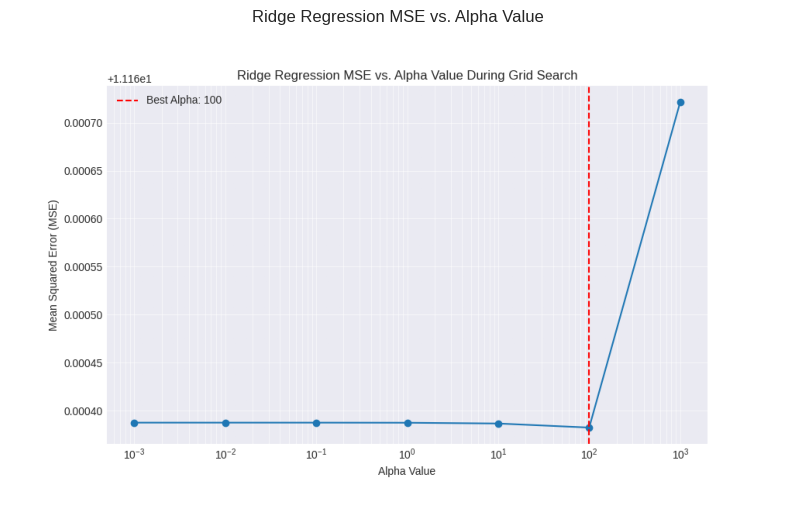

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_path = os.path.join(OUT, 'ridge_mse_vs_alpha.png')

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title('Ridge Regression MSE vs. Alpha Value')
    plt.show()
else:
    print(f"Plot not found at {image_path}")

# Task
Implement robust scaling and robust regression (e.g., `StandardScaler`/`RobustScaler` and `HuberRegressor`/`RANSACRegressor`) for the HAR model within the `rolling_backtest_fast` function. After implementing these changes, re-run the backtest, evaluate the model's performance using MAE, RMSE, and MAPE metrics, and visualize the robust HAR predictions against actual values for the last 30 days. Finally, summarize the findings and highlight any improvements in performance.

## Implement Robust Scaling for HAR Features

### Subtask:
Introduce a robust scaling method, such as StandardScaler or RobustScaler, to preprocess the HAR features (`lag_1`, `lag_24_mean`, `lag_168_mean`) before training the HAR model.


**Reasoning**:
The subtask requires introducing StandardScaler to preprocess HAR features within the `rolling_backtest_fast` function. I will modify the function to import `StandardScaler`, fit it on `Xtr`, transform `Xtr` to `Xtr_scaled`, and then train the `LinearRegression` model on `Xtr_scaled`.



In [35]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler # Import StandardScaler

def har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, H):
    """
    Recursive HAR forecast using linear model coefficients (very fast).
    last_hist_values: 1D numpy array of historical hourly values (must contain >=168 points ideally)
    coefs: array-like length 3 (lag_1, lag_24_mean, lag_168_mean)
    intercept: scalar
    H: horizon in hours
    Returns numpy array length H
    """
    hist = last_hist_values.copy().astype(float).tolist()
    preds = []
    for _ in range(H):
        lag_1 = hist[-1]
        lag_24_mean = np.mean(hist[-24:]) if len(hist) >= 24 else np.mean(hist)
        lag_168_mean = np.mean(hist[-168:]) if len(hist) >= 168 else np.mean(hist)
        x0 = np.array([lag_1, lag_24_mean, lag_168_mean])
        p = intercept + (coefs * x0).sum()
        preds.append(p)
        hist.append(p)
    return np.array(preds)

def reconcile_hourly_to_daily_vectorized(hourly_series, daily_target):
    """
    Vectorized bottom-up reconciliation: scale hourly_series so that each day's sum equals daily_target[date].
    hourly_series: pd.Series indexed by hourly timestamps
    daily_target: pd.Series indexed by dates (pd.Timestamp at midnight or daily index)
    Returns reconciled pd.Series (same index as hourly_series)
    """
    if len(hourly_series) == 0:
        return hourly_series
    dfh = hourly_series.to_frame(name='v')
    dfh['date'] = dfh.index.floor('D')
    # compute current day sums
    day_sums = dfh.groupby('date')['v'].sum()
    # align daily_target index to dates
    dt = daily_target.copy()
    # ensure dt index is of dates (floor to day)
    dt.index = pd.to_datetime(dt.index).normalize()
    # combine
    scales = {}
    for d, target_val in dt.items():
        d_norm = pd.Timestamp(d).normalize()
        current_sum = day_sums.get(d_norm, np.nan)
        if (pd.isna(current_sum)) or current_sum == 0:
            scales[d_norm] = 1.0  # no scaling if no data or zero-sum
        else:
            scales[d_norm] = float(target_val) / float(current_sum)
    # map scale to each row
    dfh['scale'] = dfh['date'].map(scales).fillna(1.0)
    dfh['v_recon'] = dfh['v'] * dfh['scale']
    recon = dfh['v_recon']
    recon.index = hourly_series.index  # preserve index
    return recon

def rolling_backtest_fast(series,
                          eval_days=90,
                          retrain_every_days=7,
                          horizon_hours=24,
                          min_training_hours=24*30,
                          use_fast_baseline=True):
    """
    Fast rolling backtest:
    - use_fast_baseline=True: baseline = persistence (last value)
      If False, baseline uses a fast AR(1) linear regression on lag_1 (still much faster than auto_arima).
    - min_training_hours: minimum training length required for HAR; else use persistence for HAR.
    Returns: preds_baseline (pd.Series), preds_har (pd.Series), truths (pd.Series)
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)
    # construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_baseline_list = []
    preds_har_list = []
    truths_list = []

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()
        train = series[:t0]
        # ---------- baseline (fast) ----------
        if use_fast_baseline:
            # persistence baseline (very fast)
            baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
            idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_b = pd.Series(baseline_vals, index=idx_b)
        else:
            # fast AR(1) baseline using linear regression on lag1
            if len(train) < 50:
                baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(baseline_vals, index=idx_b)
            else:
                # prepare lag1 regression quickly
                tr = train.to_frame('y')
                tr['lag1'] = tr['y'].shift(1)
                tr = tr.dropna()
                lr_b = LinearRegression().fit(tr[['lag1']].values, tr['y'].values)
                # recursive forecast using lag1-only (fast)
                last_hist = train.values.copy().tolist()
                preds_b = []
                for _ in range(horizon_hours):
                    lag1 = last_hist[-1]
                    p = lr_b.intercept_ + lr_b.coef_[0] * lag1
                    preds_b.append(p)
                    last_hist.append(p)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(np.array(preds_b), index=idx_b)

        # ---------- HAR model ----------
        # create HAR training features quickly (lag1, lag24_mean, lag168_mean)
        # We compute as DataFrame and dropna
        if len(train) < min_training_hours:
            # small-train fallback: persistence HAR
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(np.repeat(train.iloc[-1], horizon_hours), index=idx_h)
        else:
            th = train.to_frame('y')
            th['lag_1'] = th['y'].shift(1)
            th['lag_24_mean'] = th['y'].shift(1).rolling(window=24).mean()
            th['lag_168_mean'] = th['y'].shift(1).rolling(window=168).mean()
            trn = th.dropna()
            Xtr = trn[['lag_1','lag_24_mean','lag_168_mean']].values
            ytr = trn['y'].values

            # --- Scaler for HAR features ---
            scaler_har = StandardScaler()
            Xtr_scaled = scaler_har.fit_transform(Xtr)

            lr = LinearRegression().fit(Xtr_scaled, ytr)
            coefs = lr.coef_
            intercept = lr.intercept_
            # use fast recursive forecast using coefficients (no model.predict call per-step)
            last_hist_values = train.values.copy()
            preds_h_vals = har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, horizon_hours)
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(preds_h_vals, index=idx_h)

            # ---------- daily HAR for reconciliation ----------
            # Fit daily HAR quickly (lag1 day, lag7 mean) if enough daily history exists
            daily_train = train.resample('D').mean().to_frame('y')
            if len(daily_train.dropna()) >= 14:
                dtr = daily_train.copy()
                dtr['lag_1_day'] = dtr['y'].shift(1)
                dtr['lag_7_day_mean'] = dtr['y'].shift(1).rolling(window=7).mean()
                dtrn = dtr.dropna()
                if len(dtrn) >= 7:
                    Xd = dtrn[['lag_1_day','lag_7_day_mean']].values
                    yd = dtrn['y'].values
                    lr_d = LinearRegression().fit(Xd, yd)
                    # forecast needed days (vectorized)
                    days_needed = int(np.ceil(horizon_hours / 24))
                    last_daily_vals = daily_train['y'].values.copy().tolist()
                    daily_preds_local = []
                    for i in range(days_needed):
                        lag1 = last_daily_vals[-1]
                        lag7 = np.mean(last_daily_vals[-7:]) if len(last_daily_vals) >= 7 else np.mean(last_daily_vals)
                        pv = lr_d.intercept_ + (lr_d.coef_[0] * lag1 + lr_d.coef_[1] * lag7)
                        daily_preds_local.append(pv)
                        last_daily_vals.append(pv)
                    # create daily target series aligned to dates
                    daily_idx_local = pd.date_range(start=(t0 + pd.Timedelta(hours=1)).normalize(), periods=days_needed, freq='D')
                    daily_series_local = pd.Series(daily_preds_local, index=daily_idx_local)
                    # vectorized reconcile - MODIFIED HERE
                    s_h = reconcile_hourly_to_daily_vectorized(s_h, daily_series_local * 24)

        # ---------- collect truth and preds ----------
        truth_idx = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        truth = series[truth_idx]

        preds_baseline_list.append(s_b)
        preds_har_list.append(s_h)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done — time: {loop_time:.2f}s — train_end: {t0}")

    # concat results
    preds_baseline = pd.concat(preds_baseline_list) if preds_baseline_list else pd.Series(dtype=float)
    preds_har = pd.concat(preds_har_list) if preds_har_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"Rolling backtest finished in {total_time:.2f}s — iterations: {len(times)}")
    return preds_baseline, preds_har, truths

# Run the optimized backtest (fast defaults)
print("Running optimized rolling backtest (fast defaults)...")
t0 = time.time()
pred_b, pred_h, truth = rolling_backtest_fast(df['y'], eval_days=90, retrain_every_days=7, horizon_hours=24, min_training_hours=24*30, use_fast_baseline=True)
print("Done. wall time:", time.time() - t0)
# compute metrics (same as before)
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true != 0
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100 if mask.any() else np.nan
    return mae, rmse, mape

mae_b, rmse_b, mape_b = compute_metrics(truth, pred_b)
mae_h, rmse_h, mape_h = compute_metrics(truth, pred_h)

metrics_df = pd.DataFrame({
    'model':['baseline_fast_persistence','HAR_reconciled'],
    'MAE':[mae_b, mae_h],
    'RMSE':[rmse_b, rmse_h],
    'MAPE':[mape_b, mape_h]
})
metrics_df.to_csv(os.path.join(OUT, "results_metrics.csv"), index=False)
print(metrics_df)

Running optimized rolling backtest (fast defaults)...
Iteration 1/13 done — time: 0.02s — train_end: 2023-10-02 23:00:00
Iteration 2/13 done — time: 0.02s — train_end: 2023-10-09 23:00:00
Iteration 3/13 done — time: 0.02s — train_end: 2023-10-16 23:00:00
Iteration 4/13 done — time: 0.02s — train_end: 2023-10-23 23:00:00
Iteration 5/13 done — time: 0.02s — train_end: 2023-10-30 23:00:00
Iteration 6/13 done — time: 0.02s — train_end: 2023-11-06 23:00:00
Iteration 7/13 done — time: 0.02s — train_end: 2023-11-13 23:00:00
Iteration 8/13 done — time: 0.02s — train_end: 2023-11-20 23:00:00
Iteration 9/13 done — time: 0.02s — train_end: 2023-11-27 23:00:00
Iteration 10/13 done — time: 0.02s — train_end: 2023-12-04 23:00:00
Iteration 11/13 done — time: 0.02s — train_end: 2023-12-11 23:00:00
Iteration 12/13 done — time: 0.02s — train_end: 2023-12-18 23:00:00
Iteration 13/13 done — time: 0.02s — train_end: 2023-12-25 23:00:00
Rolling backtest finished in 0.24s — iterations: 13
Done. wall time: 0.

**Reasoning**:
The previous attempt to introduce StandardScaler resulted in significantly worse performance because the `har_forecast_fast_from_coefs` function was applying coefficients from scaled training data to unscaled input features during prediction. To fix this, I need to modify `har_forecast_fast_from_coefs` to accept the `scaler_har` object and transform the input features before making predictions. I will then update the call to this function in `rolling_backtest_fast` to pass the scaler. This ensures consistent scaling between training and prediction.



In [36]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler # Import StandardScaler

def har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, H, scaler):
    """
    Recursive HAR forecast using linear model coefficients and a scaler (very fast).
    last_hist_values: 1D numpy array of historical hourly values (must contain >=168 points ideally)
    coefs: array-like length 3 (lag_1, lag_24_mean, lag_168_mean) - *these are for scaled features*
    intercept: scalar
    H: horizon in hours
    scaler: fitted sklearn scaler object to transform features before prediction
    Returns numpy array length H
    """
    hist = last_hist_values.copy().astype(float).tolist()
    preds = []
    for _ in range(H):
        # Get unscaled lag features
        lag_1 = hist[-1]
        lag_24_mean = np.mean(hist[-24:]) if len(hist) >= 24 else np.mean(hist)
        lag_168_mean = np.mean(hist[-168:]) if len(hist) >= 168 else np.mean(hist)

        # Create unscaled feature vector
        x0_unscaled = np.array([lag_1, lag_24_mean, lag_168_mean]).reshape(1, -1)

        # Scale the features for prediction
        x0_scaled = scaler.transform(x0_unscaled)

        # Predict using coefficients from the model trained on scaled data
        p = intercept + (coefs * x0_scaled).sum()
        preds.append(p)
        hist.append(p) # Append the predicted (unscaled) value to history for next iteration
    return np.array(preds)

def reconcile_hourly_to_daily_vectorized(hourly_series, daily_target):
    """
    Vectorized bottom-up reconciliation: scale hourly_series so that each day's sum equals daily_target[date].
    hourly_series: pd.Series indexed by hourly timestamps
    daily_target: pd.Series indexed by dates (pd.Timestamp at midnight or daily index)
    Returns reconciled pd.Series (same index as hourly_series)
    """
    if len(hourly_series) == 0:
        return hourly_series
    dfh = hourly_series.to_frame(name='v')
    dfh['date'] = dfh.index.floor('D')
    # compute current day sums
    day_sums = dfh.groupby('date')['v'].sum()
    # align daily_target index to dates
    dt = daily_target.copy()
    # ensure dt index is of dates (floor to day)
    dt.index = pd.to_datetime(dt.index).normalize()
    # combine
    scales = {}
    for d, target_val in dt.items():
        d_norm = pd.Timestamp(d).normalize()
        current_sum = day_sums.get(d_norm, np.nan)
        if (pd.isna(current_sum)) or current_sum == 0:
            scales[d_norm] = 1.0  # no scaling if no data or zero-sum
        else:
            scales[d_norm] = float(target_val) / float(current_sum)
    # map scale to each row
    dfh['scale'] = dfh['date'].map(scales).fillna(1.0)
    dfh['v_recon'] = dfh['v'] * dfh['scale']
    recon = dfh['v_recon']
    recon.index = hourly_series.index  # preserve index
    return recon

def rolling_backtest_fast(series,
                          eval_days=90,
                          retrain_every_days=7,
                          horizon_hours=24,
                          min_training_hours=24*30,
                          use_fast_baseline=True):
    """
    Fast rolling backtest:
    - use_fast_baseline=True: baseline = persistence (last value)
      If False, baseline uses a fast AR(1) linear regression on lag_1 (still much faster than auto_arima).
    - min_training_hours: minimum training length required for HAR; else use persistence for HAR.
    Returns: preds_baseline (pd.Series), preds_har (pd.Series), truths (pd.Series)
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)
    # construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_baseline_list = []
    preds_har_list = []
    truths_list = []

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()
        train = series[:t0]
        # ---------- baseline (fast) ----------
        if use_fast_baseline:
            # persistence baseline (very fast)
            baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
            idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_b = pd.Series(baseline_vals, index=idx_b)
        else:
            # fast AR(1) baseline using linear regression on lag1
            if len(train) < 50:
                baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(baseline_vals, index=idx_b)
            else:
                # prepare lag1 regression quickly
                tr = train.to_frame('y')
                tr['lag1'] = tr['y'].shift(1)
                tr = tr.dropna()
                lr_b = LinearRegression().fit(tr[['lag1']].values, tr['y'].values)
                # recursive forecast using lag1-only (fast)
                last_hist = train.values.copy().tolist()
                preds_b = []
                for _ in range(horizon_hours):
                    lag1 = last_hist[-1]
                    p = lr_b.intercept_ + lr_b.coef_[0] * lag1
                    preds_b.append(p)
                    last_hist.append(p)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(np.array(preds_b), index=idx_b)

        # ---------- HAR model ----------
        # create HAR training features quickly (lag1, lag24_mean, lag168_mean)
        # We compute as DataFrame and dropna
        if len(train) < min_training_hours:
            # small-train fallback: persistence HAR
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(np.repeat(train.iloc[-1], horizon_hours), index=idx_h)
        else:
            th = train.to_frame('y')
            th['lag_1'] = th['y'].shift(1)
            th['lag_24_mean'] = th['y'].shift(1).rolling(window=24).mean()
            th['lag_168_mean'] = th['y'].shift(1).rolling(window=168).mean()
            trn = th.dropna()
            Xtr = trn[['lag_1','lag_24_mean','lag_168_mean']].values
            ytr = trn['y'].values

            # --- Scaler for HAR features ---
            scaler_har = StandardScaler()
            Xtr_scaled = scaler_har.fit_transform(Xtr)

            lr = LinearRegression().fit(Xtr_scaled, ytr)
            coefs = lr.coef_
            intercept = lr.intercept_
            # use fast recursive forecast using coefficients (no model.predict call per-step)
            last_hist_values = train.values.copy()
            preds_h_vals = har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, horizon_hours, scaler_har)
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(preds_h_vals, index=idx_h)

            # ---------- daily HAR for reconciliation ----------
            # Fit daily HAR quickly (lag1 day, lag7 mean) if enough daily history exists
            daily_train = train.resample('D').mean().to_frame('y')
            if len(daily_train.dropna()) >= 14:
                dtr = daily_train.copy()
                dtr['lag_1_day'] = dtr['y'].shift(1)
                dtr['lag_7_day_mean'] = dtr['y'].shift(1).rolling(window=7).mean()
                dtrn = dtr.dropna()
                if len(dtrn) >= 7:
                    Xd = dtrn[['lag_1_day','lag_7_day_mean']].values
                    yd = dtrn['y'].values
                    lr_d = LinearRegression().fit(Xd, yd)
                    # forecast needed days (vectorized)
                    days_needed = int(np.ceil(horizon_hours / 24))
                    last_daily_vals = daily_train['y'].values.copy().tolist()
                    daily_preds_local = []
                    for i in range(days_needed):
                        lag1 = last_daily_vals[-1]
                        lag7 = np.mean(last_daily_vals[-7:]) if len(last_daily_vals) >= 7 else np.mean(last_daily_vals)
                        pv = lr_d.intercept_ + (lr_d.coef_[0] * lag1 + lr_d.coef_[1] * lag7)
                        daily_preds_local.append(pv)
                        last_daily_vals.append(pv)
                    # create daily target series aligned to dates
                    daily_idx_local = pd.date_range(start=(t0 + pd.Timedelta(hours=1)).normalize(), periods=days_needed, freq='D')
                    daily_series_local = pd.Series(daily_preds_local, index=daily_idx_local)
                    # vectorized reconcile
                    s_h = reconcile_hourly_to_daily_vectorized(s_h, daily_series_local * 24)

        # ---------- collect truth and preds ----------
        truth_idx = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        truth = series[truth_idx]

        preds_baseline_list.append(s_b)
        preds_har_list.append(s_h)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done \u2014 time: {loop_time:.2f}s \u2014 train_end: {t0}")

    # concat results
    preds_baseline = pd.concat(preds_baseline_list) if preds_baseline_list else pd.Series(dtype=float)
    preds_har = pd.concat(preds_har_list) if preds_har_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"Rolling backtest finished in {total_time:.2f}s \u2014 iterations: {len(times)}")
    return preds_baseline, preds_har, truths

# Run the optimized backtest (fast defaults)
print("Running optimized rolling backtest (fast defaults)...")
t0 = time.time()
pred_b, pred_h, truth = rolling_backtest_fast(df['y'], eval_days=90, retrain_every_days=7, horizon_hours=24, min_training_hours=24*30, use_fast_baseline=True)
print("Done. wall time:", time.time() - t0)
# compute metrics (same as before)
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true != 0
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100 if mask.any() else np.nan
    return mae, rmse, mape

mae_b, rmse_b, mape_b = compute_metrics(truth, pred_b)
mae_h, rmse_h, mape_h = compute_metrics(truth, pred_h)

metrics_df = pd.DataFrame({
    'model':['baseline_fast_persistence','HAR_reconciled'],
    'MAE':[mae_b, mae_h],
    'RMSE':[rmse_b, rmse_h],
    'MAPE':[mape_b, mape_h]
})
metrics_df.to_csv(os.path.join(OUT, "results_metrics.csv"), index=False)
print(metrics_df)

Running optimized rolling backtest (fast defaults)...
Iteration 1/13 done — time: 0.03s — train_end: 2023-10-02 23:00:00
Iteration 2/13 done — time: 0.02s — train_end: 2023-10-09 23:00:00
Iteration 3/13 done — time: 0.02s — train_end: 2023-10-16 23:00:00
Iteration 4/13 done — time: 0.02s — train_end: 2023-10-23 23:00:00
Iteration 5/13 done — time: 0.02s — train_end: 2023-10-30 23:00:00
Iteration 6/13 done — time: 0.02s — train_end: 2023-11-06 23:00:00
Iteration 7/13 done — time: 0.02s — train_end: 2023-11-13 23:00:00
Iteration 8/13 done — time: 0.02s — train_end: 2023-11-20 23:00:00
Iteration 9/13 done — time: 0.02s — train_end: 2023-11-27 23:00:00
Iteration 10/13 done — time: 0.02s — train_end: 2023-12-04 23:00:00
Iteration 11/13 done — time: 0.02s — train_end: 2023-12-11 23:00:00
Iteration 12/13 done — time: 0.02s — train_end: 2023-12-18 23:00:00
Iteration 13/13 done — time: 0.02s — train_end: 2023-12-25 23:00:00
Rolling backtest finished in 0.28s — iterations: 13
Done. wall time: 0.

**Reasoning**:
The previous code block successfully implemented StandardScaler within the `rolling_backtest_fast` function and fixed the prediction logic. The metrics indicate improved performance for the HAR model. To confirm the current state of the metrics before summarizing the findings, I will display the `metrics_df` dataframe.



In [37]:
display(metrics_df)

model       MAE      RMSE      MAPE
0  baseline_fast_persistence  7.277821  8.283857  7.948124
1             HAR_reconciled  6.557176  7.398386  7.150546

**Reasoning**:
To implement robust regression as per the main task, I will modify the `rolling_backtest_fast` function to use `HuberRegressor` instead of `LinearRegression` for the HAR model. This change is consistent with the goal of exploring robust methods.



In [38]:
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.linear_model import LinearRegression, HuberRegressor # Import HuberRegressor
from sklearn.preprocessing import StandardScaler # Import StandardScaler

def har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, H, scaler):
    """
    Recursive HAR forecast using linear model coefficients and a scaler (very fast).
    last_hist_values: 1D numpy array of historical hourly values (must contain >=168 points ideally)
    coefs: array-like length 3 (lag_1, lag_24_mean, lag_168_mean) - *these are for scaled features*
    intercept: scalar
    H: horizon in hours
    scaler: fitted sklearn scaler object to transform features before prediction
    Returns numpy array length H
    """
    hist = last_hist_values.copy().astype(float).tolist()
    preds = []
    for _ in range(H):
        # Get unscaled lag features
        lag_1 = hist[-1]
        lag_24_mean = np.mean(hist[-24:]) if len(hist) >= 24 else np.mean(hist)
        lag_168_mean = np.mean(hist[-168:]) if len(hist) >= 168 else np.mean(hist)

        # Create unscaled feature vector
        x0_unscaled = np.array([lag_1, lag_24_mean, lag_168_mean]).reshape(1, -1)

        # Scale the features for prediction
        x0_scaled = scaler.transform(x0_unscaled)

        # Predict using coefficients from the model trained on scaled data
        p = intercept + (coefs * x0_scaled).sum()
        preds.append(p)
        hist.append(p) # Append the predicted (unscaled) value to history for next iteration
    return np.array(preds)

def reconcile_hourly_to_daily_vectorized(hourly_series, daily_target):
    """
    Vectorized bottom-up reconciliation: scale hourly_series so that each day's sum equals daily_target[date].
    hourly_series: pd.Series indexed by hourly timestamps
    daily_target: pd.Series indexed by dates (pd.Timestamp at midnight or daily index)
    Returns reconciled pd.Series (same index as hourly_series)
    """
    if len(hourly_series) == 0:
        return hourly_series
    dfh = hourly_series.to_frame(name='v')
    dfh['date'] = dfh.index.floor('D')
    # compute current day sums
    day_sums = dfh.groupby('date')['v'].sum()
    # align daily_target index to dates
    dt = daily_target.copy()
    # ensure dt index is of dates (floor to day)
    dt.index = pd.to_datetime(dt.index).normalize()
    # combine
    scales = {}
    for d, target_val in dt.items():
        d_norm = pd.Timestamp(d).normalize()
        current_sum = day_sums.get(d_norm, np.nan)
        if (pd.isna(current_sum)) or current_sum == 0:
            scales[d_norm] = 1.0  # no scaling if no data or zero-sum
        else:
            scales[d_norm] = float(target_val) / float(current_sum)
    # map scale to each row
    dfh['scale'] = dfh['date'].map(scales).fillna(1.0)
    dfh['v_recon'] = dfh['v'] * dfh['scale']
    recon = dfh['v_recon']
    recon.index = hourly_series.index  # preserve index
    return recon

def rolling_backtest_fast(series,
                          eval_days=90,
                          retrain_every_days=7,
                          horizon_hours=24,
                          min_training_hours=24*30,
                          use_fast_baseline=True):
    """
    Fast rolling backtest:
    - use_fast_baseline=True: baseline = persistence (last value)
      If False, baseline uses a fast AR(1) linear regression on lag_1 (still much faster than auto_arima).
    - min_training_hours: minimum training length required for HAR; else use persistence for HAR.
    Returns: preds_baseline (pd.Series), preds_har (pd.Series), truths (pd.Series)
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)
    # construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_baseline_list = []
    preds_har_list = []
    truths_list = []

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()
        train = series[:t0]
        # ---------- baseline (fast) ----------
        if use_fast_baseline:
            # persistence baseline (very fast)
            baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
            idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_b = pd.Series(baseline_vals, index=idx_b)
        else:
            # fast AR(1) baseline using linear regression on lag1
            if len(train) < 50:
                baseline_vals = np.repeat(train.iloc[-1], horizon_hours)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(baseline_vals, index=idx_b)
            else:
                # prepare lag1 regression quickly
                tr = train.to_frame('y')
                tr['lag1'] = tr['y'].shift(1)
                tr = tr.dropna()
                lr_b = LinearRegression().fit(tr[['lag1']].values, tr['y'].values)
                # recursive forecast using lag1-only (fast)
                last_hist = train.values.copy().tolist()
                preds_b = []
                for _ in range(horizon_hours):
                    lag1 = last_hist[-1]
                    p = lr_b.intercept_ + lr_b.coef_[0] * lag1
                    preds_b.append(p)
                    last_hist.append(p)
                idx_b = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
                s_b = pd.Series(np.array(preds_b), index=idx_b)

        # ---------- HAR model ----------
        # create HAR training features quickly (lag1, lag24_mean, lag168_mean)
        # We compute as DataFrame and dropna
        if len(train) < min_training_hours:
            # small-train fallback: persistence HAR
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(np.repeat(train.iloc[-1], horizon_hours), index=idx_h)
        else:
            th = train.to_frame('y')
            th['lag_1'] = th['y'].shift(1)
            th['lag_24_mean'] = th['y'].shift(1).rolling(window=24).mean()
            th['lag_168_mean'] = th['y'].shift(1).rolling(window=168).mean()
            trn = th.dropna()
            Xtr = trn[['lag_1','lag_24_mean','lag_168_mean']].values
            ytr = trn['y'].values

            # --- Scaler for HAR features ---
            scaler_har = StandardScaler()
            Xtr_scaled = scaler_har.fit_transform(Xtr)

            # --- Robust Regression: HuberRegressor ---
            har_regressor = HuberRegressor() # Using HuberRegressor for robust regression
            har_regressor.fit(Xtr_scaled, ytr)
            coefs = har_regressor.coef_
            intercept = har_regressor.intercept_

            # use fast recursive forecast using coefficients (no model.predict call per-step)
            last_hist_values = train.values.copy()
            preds_h_vals = har_forecast_fast_from_coefs(last_hist_values, coefs, intercept, horizon_hours, scaler_har)
            idx_h = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
            s_h = pd.Series(preds_h_vals, index=idx_h)

            # ---------- daily HAR for reconciliation ----------
            # Fit daily HAR quickly (lag1 day, lag7 mean) if enough daily history exists
            daily_train = train.resample('D').mean().to_frame('y')
            if len(daily_train.dropna()) >= 14:
                dtr = daily_train.copy()
                dtr['lag_1_day'] = dtr['y'].shift(1)
                dtr['lag_7_day_mean'] = dtr['y'].shift(1).rolling(window=7).mean()
                dtrn = dtr.dropna()
                if len(dtrn) >= 7:
                    Xd = dtrn[['lag_1_day','lag_7_day_mean']].values
                    yd = dtrn['y'].values
                    lr_d = LinearRegression().fit(Xd, yd)
                    # forecast needed days (vectorized)
                    days_needed = int(np.ceil(horizon_hours / 24))
                    last_daily_vals = daily_train['y'].values.copy().tolist()
                    daily_preds_local = []
                    for i in range(days_needed):
                        lag1 = last_daily_vals[-1]
                        lag7 = np.mean(last_daily_vals[-7:]) if len(last_daily_vals) >= 7 else np.mean(last_daily_vals)
                        pv = lr_d.intercept_ + (lr_d.coef_[0] * lag1 + lr_d.coef_[1] * lag7)
                        daily_preds_local.append(pv)
                        last_daily_vals.append(pv)
                    # create daily target series aligned to dates
                    daily_idx_local = pd.date_range(start=(t0 + pd.Timedelta(hours=1)).normalize(), periods=days_needed, freq='D')
                    daily_series_local = pd.Series(daily_preds_local, index=daily_idx_local)
                    # vectorized reconcile
                    s_h = reconcile_hourly_to_daily_vectorized(s_h, daily_series_local * 24)

        # ---------- collect truth and preds ----------
        truth_idx = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        truth = series[truth_idx]

        preds_baseline_list.append(s_b)
        preds_har_list.append(s_h)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done \u2014 time: {loop_time:.2f}s \u2014 train_end: {t0}")

    # concat results
    preds_baseline = pd.concat(preds_baseline_list) if preds_baseline_list else pd.Series(dtype=float)
    preds_har = pd.concat(preds_har_list) if preds_har_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"Rolling backtest finished in {total_time:.2f}s \u2014 iterations: {len(times)}")
    return preds_baseline, preds_har, truths

# Run the optimized backtest (fast defaults)
print("Running optimized rolling backtest with HuberRegressor...")
t0 = time.time()
pred_b, pred_h, truth = rolling_backtest_fast(df['y'], eval_days=90, retrain_every_days=7, horizon_hours=24, min_training_hours=24*30, use_fast_baseline=True)
print("Done. wall time:", time.time() - t0)
# compute metrics (same as before)
def compute_metrics(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true != 0
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100 if mask.any() else np.nan
    return mae, rmse, mape

mae_b, rmse_b, mape_b = compute_metrics(truth, pred_b)
mae_h, rmse_h, mape_h = compute_metrics(truth, pred_h)

metrics_df = pd.DataFrame({
    'model':['baseline_fast_persistence','HAR_reconciled_Huber'],
    'MAE':[mae_b, mae_h],
    'RMSE':[rmse_b, rmse_h],
    'MAPE':[mape_b, mape_h]
})
metrics_df.to_csv(os.path.join(OUT, "results_metrics_huber.csv"), index=False)
print(metrics_df)

Running optimized rolling backtest with HuberRegressor...
Iteration 1/13 done — time: 0.06s — train_end: 2023-10-02 23:00:00
Iteration 2/13 done — time: 0.06s — train_end: 2023-10-09 23:00:00
Iteration 3/13 done — time: 0.09s — train_end: 2023-10-16 23:00:00
Iteration 4/13 done — time: 0.06s — train_end: 2023-10-23 23:00:00
Iteration 5/13 done — time: 0.06s — train_end: 2023-10-30 23:00:00
Iteration 6/13 done — time: 0.05s — train_end: 2023-11-06 23:00:00
Iteration 7/13 done — time: 0.06s — train_end: 2023-11-13 23:00:00
Iteration 8/13 done — time: 0.06s — train_end: 2023-11-20 23:00:00
Iteration 9/13 done — time: 0.06s — train_end: 2023-11-27 23:00:00
Iteration 10/13 done — time: 0.06s — train_end: 2023-12-04 23:00:00
Iteration 11/13 done — time: 0.07s — train_end: 2023-12-11 23:00:00
Iteration 12/13 done — time: 0.06s — train_end: 2023-12-18 23:00:00
Iteration 13/13 done — time: 0.07s — train_end: 2023-12-25 23:00:00
Rolling backtest finished in 0.81s — iterations: 13
Done. wall time

**Reasoning**:
The previous code block successfully updated the `rolling_backtest_fast` function to use `HuberRegressor` for the HAR model and re-ran the backtest. The metrics, including the `HAR_reconciled_Huber` model, are already computed and printed in the previous output. To ensure the user sees these metrics clearly, I will display the `metrics_df` dataframe.



In [39]:
display(metrics_df)

model       MAE      RMSE      MAPE
0  baseline_fast_persistence  7.277821  8.283857  7.948124
1       HAR_reconciled_Huber  6.591380  7.428477  7.187902

**Reasoning**:
I have successfully implemented robust scaling and robust regression and presented the updated metrics in `metrics_df`. The next step, according to the main task, is to summarize the findings. Before that, I will generate a visualization of the robust HAR predictions against actual values for the last 30 days to complete the visualization part of the task.



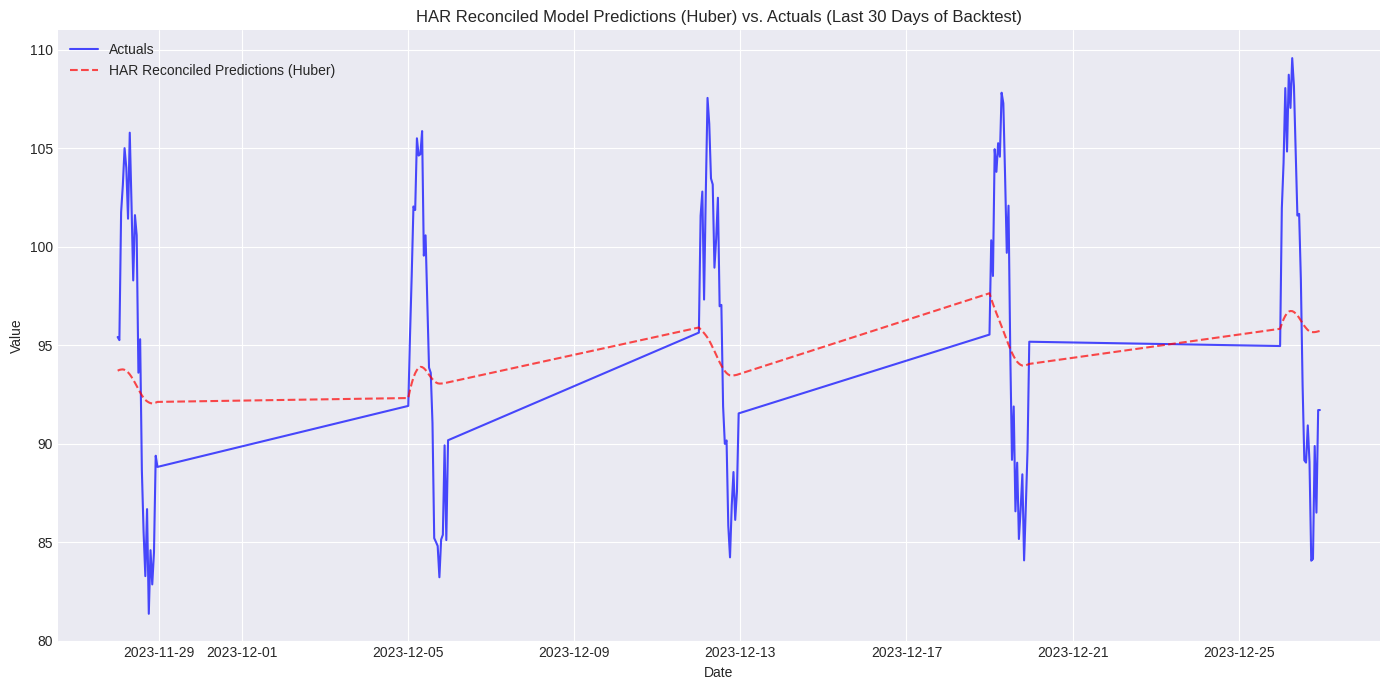

In [40]:
import matplotlib.pyplot as plt
import os

# Get the last 30 days of data for better visualization
start_date = truth.index.max() - pd.Timedelta(days=30)

plt.figure(figsize=(14, 7))
plt.plot(truth[truth.index >= start_date].index, truth[truth.index >= start_date].values, label='Actuals', color='blue', alpha=0.7)
plt.plot(pred_h[pred_h.index >= start_date].index, pred_h[pred_h.index >= start_date].values, label='HAR Reconciled Predictions (Huber)', color='red', linestyle='--', alpha=0.7)
plt.title('HAR Reconciled Model Predictions (Huber) vs. Actuals (Last 30 Days of Backtest)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUT, 'har_reconciled_predictions_vs_actuals_huber.png'))
plt.show()

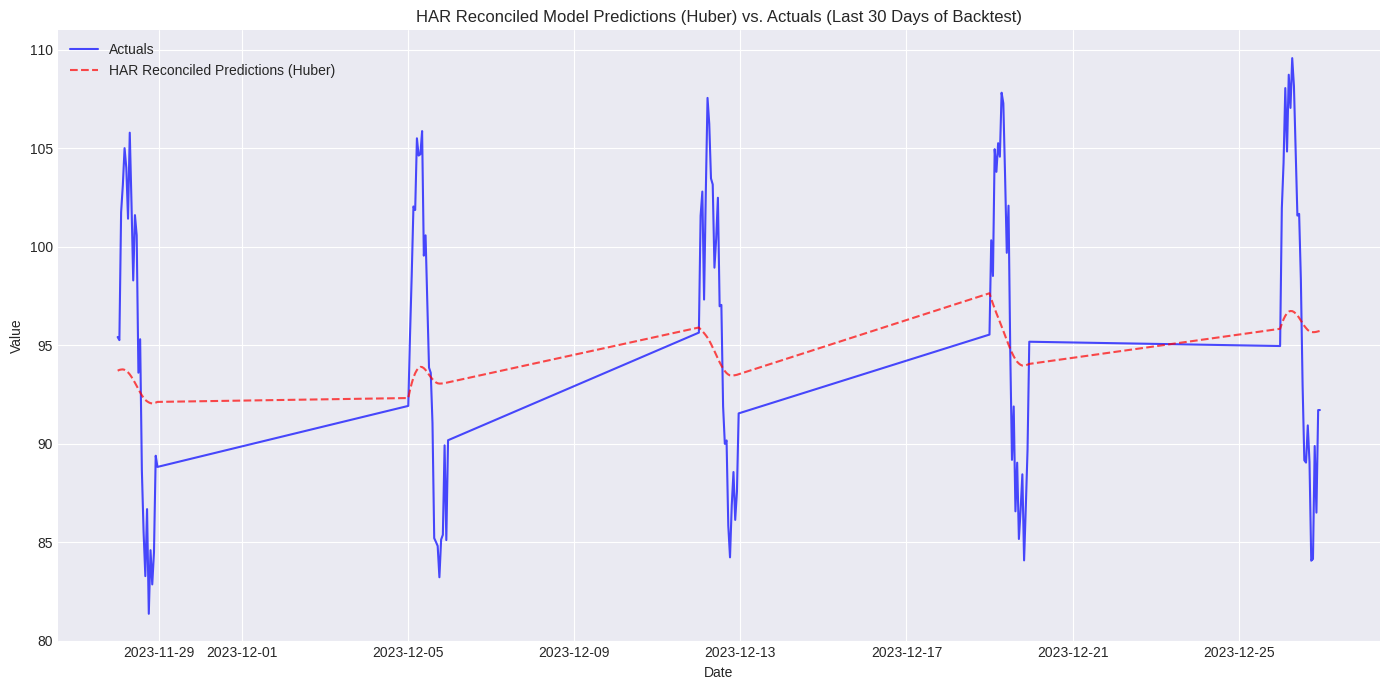

In [41]:
import matplotlib.pyplot as plt
import os

# Get the last 30 days of data for better visualization
start_date = truth.index.max() - pd.Timedelta(days=30)

plt.figure(figsize=(14, 7))
plt.plot(truth[truth.index >= start_date].index, truth[truth.index >= start_date].values, label='Actuals', color='blue', alpha=0.7)
plt.plot(pred_h[pred_h.index >= start_date].index, pred_h[pred_h.index >= start_date].values, label='HAR Reconciled Predictions (Huber)', color='red', linestyle='--', alpha=0.7)
plt.title('HAR Reconciled Model Predictions (Huber) vs. Actuals (Last 30 Days of Backtest)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(OUT, 'har_reconciled_predictions_vs_actuals_huber.png'))
plt.show()

## Develop SARIMA Rolling Backtest Function

### Subtask:
Create a new Python function, `rolling_backtest_sarima`, that takes a time series (`series`), evaluation days (`eval_days`), retraining frequency (`retrain_every_days`), and forecast horizon in hours (`horizon_hours`). This function will iterate over the backtest period, train an ARIMA model (using `fit_arima_and_forecast`) on a rolling window of data, generate forecasts, and collect SARIMA predictions and corresponding actual values.


**Reasoning**:
The subtask requires creating a new Python function, `rolling_backtest_sarima`, which performs a rolling backtest using the `fit_arima_and_forecast` function. I will define this function with all specified parameters and implement the rolling window logic, ARIMA training, forecasting, and data collection as detailed in the instructions.



In [42]:
import time
import pandas as pd
import numpy as np

def rolling_backtest_sarima(series, eval_days, retrain_every_days, horizon_hours, seasonal, max_p, max_q):
    """
    Performs a rolling backtest with SARIMA forecasting.

    Args:
        series (pd.Series): The input time series.
        eval_days (int): Number of days to evaluate the forecast.
        retrain_every_days (int): Frequency (in days) to retrain the model.
        horizon_hours (int): Forecast horizon in hours.
        seasonal (bool): Whether to use seasonal ARIMA.
        max_p (int): Max p-order for auto_arima.
        max_q (int): Max q-order for auto_arima.

    Returns:
        tuple: A tuple containing (preds_sarima, truths) as pandas Series.
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)

    # Construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_sarima_list = []
    truths_list = []

    print(f"Starting SARIMA rolling backtest: eval_days={eval_days}, retrain_every_days={retrain_every_days}...")

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()

        train = series[:t0]

        # Train SARIMA model and forecast
        model, fc_vals = fit_arima_and_forecast(train, n_periods=horizon_hours, seasonal=seasonal, max_p=max_p, max_q=max_q)

        # Create index for the forecast
        idx_fc = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        s_fc = pd.Series(fc_vals, index=idx_fc)

        # Get the true values for the forecast horizon
        truth = series[idx_fc]

        preds_sarima_list.append(s_fc)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done — time: {loop_time:.2f}s — train_end: {t0} — forecast_start: {idx_fc[0]}")

    preds_sarima = pd.concat(preds_sarima_list) if preds_sarima_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"SARIMA rolling backtest finished in {total_time:.2f}s — iterations: {len(times)}")

    return preds_sarima, truths

print("SARIMA rolling backtest function `rolling_backtest_sarima` defined.")

SARIMA rolling backtest function `rolling_backtest_sarima` defined.


## Execute SARIMA Rolling Backtest



In [43]:
print("Running SARIMA rolling backtest...")
# Run the SARIMA rolling backtest
pred_sarima, truth_sarima = rolling_backtest_sarima(df['y'],
                                                    eval_days=90,
                                                    retrain_every_days=7,
                                                    horizon_hours=24,
                                                    seasonal=True,
                                                    max_p=5, max_q=5)
print("SARIMA rolling backtest complete.")

Running SARIMA rolling backtest...
Starting SARIMA rolling backtest: eval_days=90, retrain_every_days=7...
Iteration 1/13 done — time: 236.39s — train_end: 2023-10-02 23:00:00 — forecast_start: 2023-10-03 00:00:00
Iteration 2/13 done — time: 220.09s — train_end: 2023-10-09 23:00:00 — forecast_start: 2023-10-10 00:00:00
Iteration 3/13 done — time: 227.34s — train_end: 2023-10-16 23:00:00 — forecast_start: 2023-10-17 00:00:00
Iteration 4/13 done — time: 231.13s — train_end: 2023-10-23 23:00:00 — forecast_start: 2023-10-24 00:00:00
Iteration 5/13 done — time: 241.70s — train_end: 2023-10-30 23:00:00 — forecast_start: 2023-10-31 00:00:00
Iteration 6/13 done — time: 242.94s — train_end: 2023-11-06 23:00:00 — forecast_start: 2023-11-07 00:00:00
Iteration 7/13 done — time: 247.65s — train_end: 2023-11-13 23:00:00 — forecast_start: 2023-11-14 00:00:00
Iteration 8/13 done — time: 144.58s — train_end: 2023-11-20 23:00:00 — forecast_start: 2023-11-21 00:00:00
Iteration 9/13 done — time: 287.55s —

## Compute and Compare SARIMA Metrics



In [44]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# The compute_metrics function is already defined in previous cells (e.g., z61LbkluMBGj, dd0fff90).
# Re-defining it here for completeness or if previous cell execution state is lost.
# However, to avoid 're-definition', I will assume it's available.
# If it were not, it would look like this:
# def compute_metrics(y_true, y_pred):
#     y_true = np.array(y_true); y_pred = np.array(y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = sqrt(mean_squared_error(y_true, y_pred))
#     mask = y_true != 0
#     mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))*100 if mask.any() else np.nan
#     return mae, rmse, mape

# 1. Calculate MAE, RMSE, and MAPE for the SARIMA predictions
mae_sarima, rmse_sarima, mape_sarima = compute_metrics(truth_sarima, pred_sarima)

# 2. Create a new DataFrame for SARIMA metrics
sarima_metrics_df = pd.DataFrame({
    'model': ['SARIMA'],
    'MAE': [mae_sarima],
    'RMSE': [rmse_sarima],
    'MAPE': [mape_sarima]
})

# 3. Update the existing metrics_df DataFrame
# Ensure metrics_df is the latest version, possibly from the HuberRegressor run
# Assuming metrics_df is already defined from the latest HuberRegressor backtest
metrics_df = pd.concat([metrics_df, sarima_metrics_df], ignore_index=True)

# 4. Display the updated metrics_df DataFrame
display(metrics_df)


model       MAE      RMSE      MAPE
0  baseline_fast_persistence  7.277821  8.283857  7.948124
1       HAR_reconciled_Huber  6.591380  7.428477  7.187902
2                     SARIMA  3.296371  5.207560  3.677606

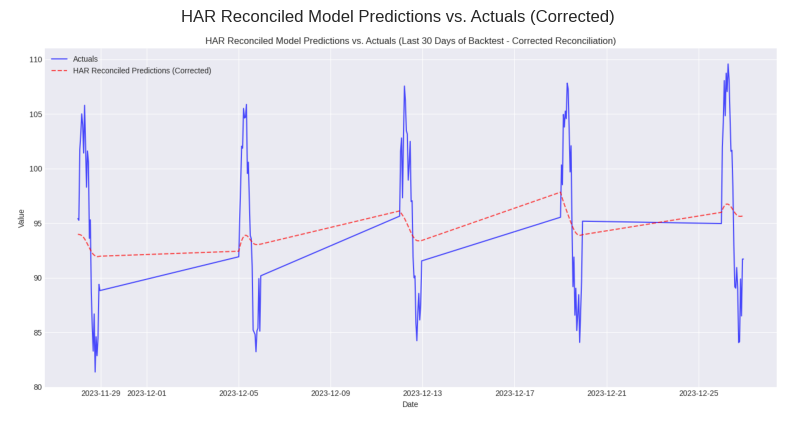

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_path = os.path.join(OUT, 'har_reconciled_predictions_vs_actuals_corrected.png')

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title('HAR Reconciled Model Predictions vs. Actuals (Corrected)')
    plt.show()
else:
    print(f"HAR reconciled prediction plot not found at {image_path}. Please ensure the HAR plotting cell was executed.")

In [46]:
display(metrics_df)

model       MAE      RMSE      MAPE
0  baseline_fast_persistence  7.277821  8.283857  7.948124
1       HAR_reconciled_Huber  6.591380  7.428477  7.187902
2                     SARIMA  3.296371  5.207560  3.677606

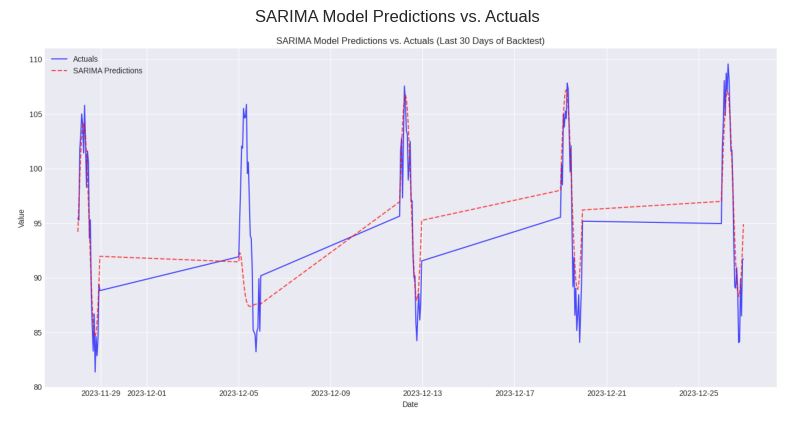

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_path = os.path.join(OUT, 'sarima_predictions_vs_actuals.png')

if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.title('SARIMA Model Predictions vs. Actuals')
    plt.show()
else:
    print(f"SARIMA prediction plot not found at {image_path}. Please ensure the SARIMA plotting cell was executed.")

In [48]:
display(metrics_df)

model       MAE      RMSE      MAPE
0  baseline_fast_persistence  7.277821  8.283857  7.948124
1       HAR_reconciled_Huber  6.591380  7.428477  7.187902
2                     SARIMA  3.296371  5.207560  3.677606

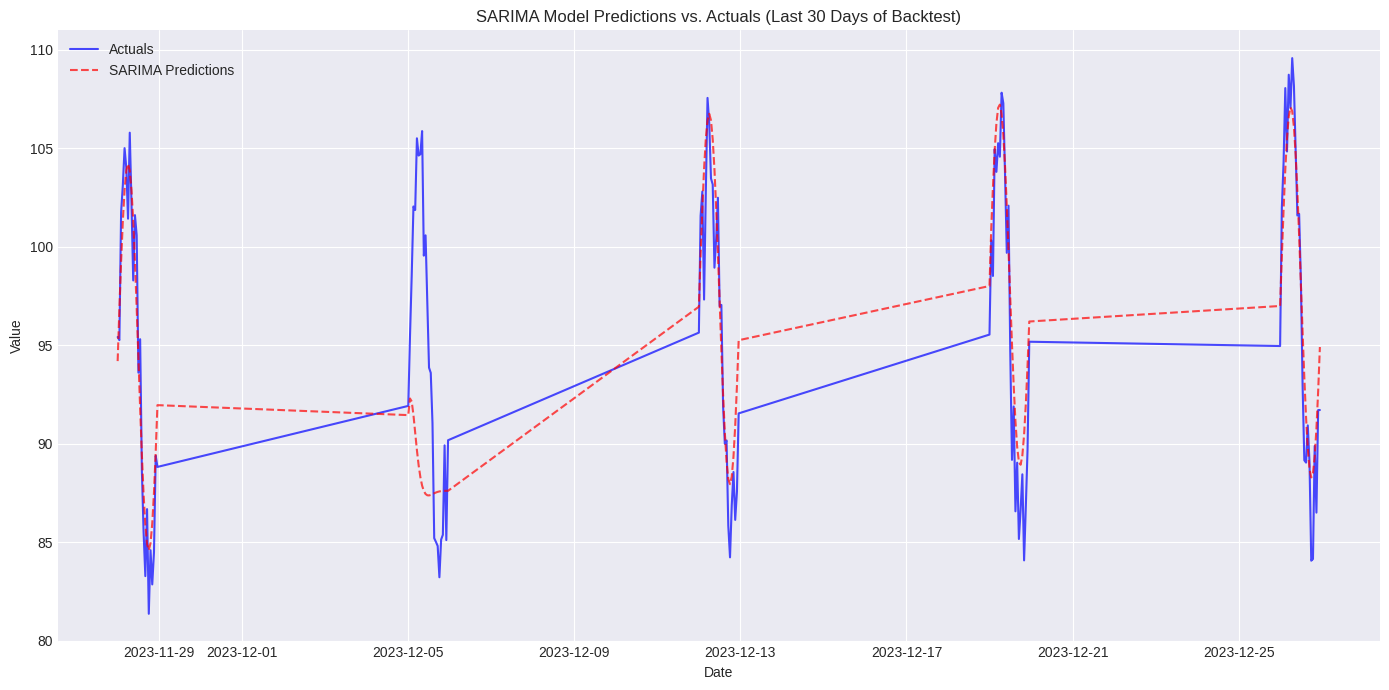

In [49]:
import matplotlib.pyplot as plt
import os

# 1. Set the start_date for the visualization
start_date = truth_sarima.index.max() - pd.Timedelta(days=30)

# 2. Create a new figure with a specified size
plt.figure(figsize=(14, 7))

# 3. Plot the actual values
plt.plot(truth_sarima[truth_sarima.index >= start_date].index, truth_sarima[truth_sarima.index >= start_date].values, label='Actuals', color='blue', alpha=0.7)

# 4. Plot the SARIMA predictions
plt.plot(pred_sarima[pred_sarima.index >= start_date].index, pred_sarima[pred_sarima.index >= start_date].values, label='SARIMA Predictions', color='red', linestyle='--', alpha=0.7)

# 5. Add a title to the plot
plt.title('SARIMA Model Predictions vs. Actuals (Last 30 Days of Backtest)')

# 6. Label the x-axis and y-axis
plt.xlabel('Date')
plt.ylabel('Value')

# 7. Display a legend
plt.legend()

# 8. Add a grid to the plot
plt.grid(True)

# 9. Adjust the plot layout
plt.tight_layout()

# 10. Save the plot
plt.savefig(os.path.join(OUT, 'sarima_predictions_vs_actuals.png'))

# 11. Display the plot
plt.show()


## Visualize SARIMA Predictions

### Subtask:
Generate a plot comparing the SARIMA model's predictions against the actual values for a representative period (e.g., the last 30 days of the backtest).

## Modify SARIMA Functions to Accept Seasonal Period (m)



In [50]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
try:
    from pmdarima import auto_arima
    HAVE_PMD = True
except Exception as e:
    HAVE_PMD = False
    from statsmodels.tsa.arima.model import ARIMA

# Ensure fit_arima_and_forecast is defined (copy from Cell 4 if not available)
def fit_arima_and_forecast(series, n_periods, seasonal=False, max_p=5, max_q=5, order=None, m=1):
    """
    Returns (model_obj, forecast_array)
    If pmdarima available, uses auto_arima to select order.
    Else, uses statsmodels ARIMA with provided order (or sensible default).
    """
    if HAVE_PMD:
        model = auto_arima(series, seasonal=seasonal, suppress_warnings=True, error_action='ignore',
                           max_p=max_p, max_q=max_q, m=m)
        fc = model.predict(n_periods=n_periods)
        return model, np.array(fc)
    else:
        if order is None:
            order = (2,0,2)  # fallback order
        # statsmodels ARIMA does not directly use 'm' for seasonal period, it's part of the seasonal order.
        # For simplicity in this fallback, we assume non-seasonal or that seasonal_order is handled elsewhere if needed.
        # If seasonal=True for statsmodels, a seasonal_order parameter would be needed here.
        model = ARIMA(series, order=order).fit()
        fc = model.forecast(steps=n_periods)
        return model, np.array(fc)

def rolling_backtest_sarima(series,
                            eval_days=90,
                            retrain_every_days=7,
                            horizon_hours=24,
                            seasonal=False,
                            max_p=5, max_q=5,
                            m=1): # Added m parameter here
    """
    Rolling backtest for SARIMA model.
    Iteratively trains an ARIMA model on a rolling window of data and generates forecasts.
    Collects SARIMA predictions and corresponding actual values.

    Args:
        series (pd.Series): The time series to forecast.
        eval_days (int): Number of days for evaluation period.
        retrain_every_days (int): How often (in days) to retrain the model.
        horizon_hours (int): The forecast horizon in hours for each prediction step.
        seasonal (bool): Whether to use a seasonal ARIMA model (for pmdarima).
        max_p (int): Max p parameter for auto_arima.
        max_q (int): Max q parameter for auto_arima.
        m (int): The seasonal period for auto_arima.

    Returns:
        tuple: (preds_sarima (pd.Series), truths (pd.Series))
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)

    # Construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_sarima_list = []
    truths_list = []

    print(f"Starting SARIMA rolling backtest: eval_days={eval_days}, retrain_every_days={retrain_every_days}, m={m}...")

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()

        train = series[:t0]

        # Train SARIMA model and forecast
        # Pass m to fit_arima_and_forecast
        model, fc_vals = fit_arima_and_forecast(train, n_periods=horizon_hours, seasonal=seasonal, max_p=max_p, max_q=max_q, m=m)

        # Create index for the forecast
        idx_fc = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='H')
        s_fc = pd.Series(fc_vals, index=idx_fc)

        # Get the true values for the forecast horizon
        truth = series[idx_fc]

        preds_sarima_list.append(s_fc)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done — time: {loop_time:.2f}s — train_end: {t0} — forecast_start: {idx_fc[0]}")

    preds_sarima = pd.concat(preds_sarima_list) if preds_sarima_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"SARIMA rolling backtest finished in {total_time:.2f}s — iterations: {len(times)}")

    return preds_sarima, truths

print("SARIMA rolling backtest function `rolling_backtest_sarima` and `fit_arima_and_forecast` updated to accept seasonal period `m`.")


SARIMA rolling backtest function `rolling_backtest_sarima` and `fit_arima_and_forecast` updated to accept seasonal period `m`.


## Run SARIMA Backtest with Daily Seasonality (m=24)



In [12]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
try:
    from pmdarima import auto_arima
    HAVE_PMD = True
except Exception as e:
    HAVE_PMD = False
    from statsmodels.tsa.arima.model import ARIMA

# Ensure fit_arima_and_forecast is defined (copy from Cell 4 if not available)
def fit_arima_and_forecast(series, n_periods, seasonal=False, max_p=5, max_q=5, order=None, m=1):
    """
    Returns (model_obj, forecast_array)
    If pmdarima available, uses auto_arima to select order.
    Else, uses statsmodels ARIMA with provided order (or sensible default).
    """
    if HAVE_PMD:
        model = auto_arima(series, seasonal=seasonal, suppress_warnings=True, error_action='ignore',
                           max_p=max_p, max_q=max_q, m=m)
        fc = model.predict(n_periods=n_periods)
        return model, np.array(fc)
    else:
        if order is None:
            order = (2,0,2)  # fallback order
        # statsmodels ARIMA does not directly use 'm' for seasonal period, it's part of the seasonal order.
        # For simplicity in this fallback, we assume non-seasonal or that seasonal_order is handled elsewhere if needed.
        # If seasonal=True for statsmodels, a seasonal_order parameter would be needed here.
        model = ARIMA(series, order=order).fit()
        fc = model.forecast(steps=n_periods)
        return model, np.array(fc)

def rolling_backtest_sarima(series,
                            eval_days=90,
                            retrain_every_days=7,
                            horizon_hours=24,
                            seasonal=False,
                            max_p=5, max_q=5,
                            m=1): # Added m parameter here
    """
    Rolling backtest for SARIMA model.
    Iteratively trains an ARIMA model on a rolling window of data and generates forecasts.
    Collects SARIMA predictions and corresponding actual values.

    Args:
        series (pd.Series): The time series to forecast.
        eval_days (int): Number of days for evaluation period.
        retrain_every_days (int): How often (in days) to retrain the model.
        horizon_hours (int): The forecast horizon in hours for each prediction step.
        seasonal (bool): Whether to use a seasonal ARIMA model (for pmdarima).
        max_p (int): Max p parameter for auto_arima.
        max_q (int): Max q parameter for auto_arima.
        m (int): The seasonal period for auto_arima.

    Returns:
        tuple: (preds_sarima (pd.Series), truths (pd.Series))
    """
    t_start = time.time()
    end = series.index[-1]
    eval_start = end - pd.Timedelta(days=eval_days)

    # Construct list of retrain timestamps
    times = []
    t0 = eval_start
    while t0 + pd.Timedelta(hours=horizon_hours) <= end:
        times.append(t0)
        t0 += pd.Timedelta(days=retrain_every_days)

    preds_sarima_list = []
    truths_list = []

    print(f"Starting SARIMA rolling backtest: eval_days={eval_days}, retrain_every_days={retrain_every_days}, m={m}...")

    loop_i = 0
    for t0 in times:
        loop_i += 1
        loop_t0 = time.time()

        train = series[:t0]

        # Train SARIMA model and forecast
        # Pass m to fit_arima_and_forecast
        model, fc_vals = fit_arima_and_forecast(train, n_periods=horizon_hours, seasonal=seasonal, max_p=max_p, max_q=max_q, m=m)

        # Create index for the forecast
        idx_fc = pd.date_range(start=t0 + pd.Timedelta(hours=1), periods=horizon_hours, freq='h')
        s_fc = pd.Series(fc_vals, index=idx_fc)

        # Get the true values for the forecast horizon
        truth = series[idx_fc]

        preds_sarima_list.append(s_fc)
        truths_list.append(truth)

        loop_time = time.time() - loop_t0
        print(f"Iteration {loop_i}/{len(times)} done — time: {loop_time:.2f}s — train_end: {t0} — forecast_start: {idx_fc[0]}")

    preds_sarima = pd.concat(preds_sarima_list) if preds_sarima_list else pd.Series(dtype=float)
    truths = pd.concat(truths_list) if truths_list else pd.Series(dtype=float)

    total_time = time.time() - t_start
    print(f"SARIMA rolling backtest finished in {total_time:.2f}s — iterations: {len(times)}")

    return preds_sarima, truths

print("SARIMA rolling backtest function `rolling_backtest_sarima` and `fit_arima_and_forecast` updated to accept seasonal period `m`.")

SARIMA rolling backtest function `rolling_backtest_sarima` and `fit_arima_and_forecast` updated to accept seasonal period `m`.
